In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc
import keras

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation
from evaluation import calculate_metrics, evaluate_metadata, evaluate_metadata_raw

Using TensorFlow backend.


In [2]:
### from https://github.com/google-research/exoplanet-ml/blob/master/exoplanet-ml/light_curve/util.py

def phase_fold_time(time, period, t0):
  """Creates a phase-folded time vector.
  result[i] is the unique number in [-period / 2, period / 2)
  such that result[i] = time[i] - t0 + k_i * period, for some integer k_i.
  Args:
    time: 1D numpy array of time values.
    period: A positive real scalar; the period to fold over.
    t0: The center of the resulting folded vector; this value is mapped to 0.
  Returns:
    A 1D numpy array.
  """
  half_period = period / 2
  result = np.mod(time + (half_period - t0), period)
  result -= half_period
  return result

def phase_fold_and_sort_light_curve(time, values, period, t0):
  """Phase folds a light curve and sorts by ascending time.
  Args:
    time: 1D NumPy array of time values.
    values: N-dimensional NumPy array with the same length as time.
    period: A positive real scalar; the period to fold over.
    t0: The center of the resulting folded vector; this value is mapped to 0.
  Returns:
    folded_time: 1D NumPy array of phase folded time values in
        [-period / 2, period / 2), where 0 corresponds to t0 in the original
        time array. Values are sorted in ascending order.
    folded_values: NumPy array. Values are the same as the original values
        array, but sorted by folded_time.
  """
  # Phase fold time.
  time = phase_fold_time(time, period, t0)

  # Sort by ascending time.
  sorted_i = np.argsort(time)
  time = time[sorted_i]
  values = values[sorted_i]

  return time, values

def generate_view(time,
                  values,
                  num_bins,
                  bin_width,
                  t_min,
                  t_max,
                  normalize=True):
  """Generates a view of a phase-folded and binned light curve.
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    num_bins: The number of intervals to divide the time axis into.
    bin_width: The width of each bin on the time axis.
    t_min: The inclusive leftmost value to consider on the time axis.
    t_max: The exclusive rightmost value to consider on the time axis.
    normalize: Whether to center the median at 0 and minimum value at -1.
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  view, bin_counts = bin_and_aggregate(time, values, num_bins,
                                               bin_width, t_min, t_max)
  # Empty bins fall back to the global median.
  fill_v = np.median(values)
  view = np.where(bin_counts > 0, view, fill_v )
  return view

def global_view(time, values, period, num_bins=2001, bin_width_factor=1 / 2001):
  """Generates a 'global view' of a phase folded light curve.
  See Section 3.3 of Shallue & Vanderburg, 2018, The Astronomical Journal.
  http://iopscience.iop.org/article/10.3847/1538-3881/aa9e09/meta
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    period: The period of the event (in days).
    num_bins: The number of intervals to divide the time axis into.
    bin_width_factor: Width of the bins, as a fraction of period.
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  return generate_view(
      time,
      values,
      num_bins=num_bins,
      bin_width=period * bin_width_factor,
      t_min=-period / 2,
      t_max=period / 2)


def local_view(time,
               values,
               period,
               duration,
               num_bins=201,
               bin_width_factor=0.16,
               num_durations=4):
  """Generates a 'local view' of a phase folded light curve.
  See Section 3.3 of Shallue & Vanderburg, 2018, The Astronomical Journal.
  http://iopscience.iop.org/article/10.3847/1538-3881/aa9e09/meta
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    period: The period of the event (in days).
    duration: The duration of the event (in days).
    num_bins: The number of intervals to divide the time axis into.
    bin_width_factor: Width of the bins, as a fraction of duration.
    num_durations: The number of durations to consider on either side of 0 (the
      event is assumed to be centered at 0).
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  return generate_view(
      time,
      values,
      num_bins=num_bins,
      bin_width=duration * bin_width_factor,
      t_min=max(-period / 2, -duration * num_durations),
      t_max=min(period / 2, duration * num_durations))

def bin_and_aggregate(x,
                      y,
                      num_bins,
                      bin_width=None,
                      x_min=None,
                      x_max=None,
                      aggr_fn=None):
  """Aggregates y-values in uniform intervals (bins) along the x-axis.
  The interval [x_min, x_max) is divided into num_bins uniformly spaced
  intervals of width bin_width. The value computed for each bin is the
  aggregation of all y-values whose corresponding x-value is in the interval.
  The default aggregation function is np.median.
  NOTE: x must be sorted in ascending order or the results will be incorrect.
  Args:
    x: 1D NumPy array of x-coordinates sorted in ascending order. Must have at
      least 2 elements, and all elements cannot be the same value.
    y: N-dimensional NumPy array with the same length as x.
    num_bins: The number of intervals to divide the x-axis into. Must be at
      least 2.
    bin_width: The width of each bin on the x-axis. Must be positive, and less
      than x_max - x_min. Defaults to (x_max - x_min) / num_bins.
    x_min: The inclusive leftmost value to consider on the x-axis. Must be less
      than or equal to the largest value of x. Defaults to min(x).
    x_max: The exclusive rightmost value to consider on the x-axis. Must be
      greater than x_min. Defaults to max(x).
    aggr_fn: A function that will be called with signature aggr_fn(y, axis=0) to
      aggregate values within each bin. Default is np.median.
  Returns:
    result: NumPy array of length num_bins containing the aggregated y-values of
      uniformly spaced bins on the x-axis.
    bin_counts: 1D NumPy array of length num_bins indicating the number of
      points in each bin.
  """
  if num_bins < 2:
    raise ValueError("num_bins must be at least 2. Got: {}".format(num_bins))

  # Validate the lengths of x and y.
  x_len = len(x)
  if x_len < 2:
    raise ValueError("len(x) must be at least 2. Got: {}".format(x_len))
  if x_len != len(y):
    raise ValueError("len(x) (got: {}) must equal len(y) (got: {})".format(
        x_len, len(y)))

  # Validate x_min and x_max.
  x_min = x_min if x_min is not None else x[0]
  x_max = x_max if x_max is not None else x[-1]
  if x_min >= x_max:
    raise ValueError("x_min (got: {}) must be less than x_max (got: {})".format(
        x_min, x_max))
  if x_min > x[-1]:
    raise ValueError(
        "x_min (got: {}) must be less than or equal to the largest value of x "
        "(got: {})".format(x_min, x[-1]))

  # Validate bin_width.
  bin_width = bin_width if bin_width is not None else (x_max - x_min) / num_bins
  if bin_width <= 0:
    raise ValueError("bin_width must be positive. Got: {}".format(bin_width))
  if bin_width >= x_max - x_min:
    raise ValueError(
        "bin_width (got: {}) must be less than x_max - x_min (got: {})".format(
            bin_width, x_max - x_min))

  bin_spacing = (x_max - x_min - bin_width) / (num_bins - 1)

  if aggr_fn is None:
    aggr_fn = np.median

  # Initialize output arrays.
  # Ensure default_value is a floating point type, otherwise the aggregated
  # values may unexpectedly be cast to a non-floating type.
  default_dtype = y.dtype if isinstance(y.dtype, np.floating) else np.float
  default_value = np.zeros_like(y[0], dtype=default_dtype)
  result = np.repeat([default_value], num_bins, axis=0)
  bin_counts = np.zeros(num_bins, dtype=np.int)

  # Find the first element of x >= x_min. This loop is guaranteed to produce
  # a valid index because we know that x_min <= x[-1].
  x_start = 0
  while x[x_start] < x_min:
    x_start += 1

  # The bin at index i is the aggregation of all elements y[j] such that
  # bin_min <= x[j] < bin_max, where bin_min and bin_max are the endpoints of
  # bin i.
  bin_min = x_min  # Left endpoint of the current bin.
  bin_max = x_min + bin_width  # Right endpoint of the current bin.
  j_start = x_start  # Inclusive left index of the current bin.
  j_end = x_start  # Exclusive end index of the current bin.

  for i in range(num_bins):
    # Move j_start to the first index of x >= bin_min.
    while j_start < x_len and x[j_start] < bin_min:
      j_start += 1

    # Move j_end to the first index of x >= bin_max (exclusive end index).
    while j_end < x_len and x[j_end] < bin_max:
      j_end += 1

    if j_end > j_start:
      # Compute and insert the aggregate y value in the bin.
      result[i] = aggr_fn(y[j_start:j_end], axis=0)
      bin_counts[i] = j_end - j_start

    # Advance the bin.
    bin_min += bin_spacing
    bin_max += bin_spacing

  return result, bin_counts

In [3]:
def generate_sin(N=10000, sigma =1):
    per = np.random.uniform(0.1, 100)
    t0 = np.random.uniform(0.1, per*0.5)
    T_n = np.random.exponential(5)
        
    sigma = per*0.1 #np.min([per*0.1, sigma])
    
    t = np.linspace(0, T_n*per, N) +np.random.normal(0, scale=sigma, size=N) #np.minimum(dif_0, np.maximum(-dif_0 , np.random.normal(0,scale=1, size=N) ))
    
    t += np.abs(t.min())
    t = np.sort(t)
    
    data = 3.0*np.sin(2*np.pi*t/per + t0) + np.random.randn(N) # create artificial data with noise
    
    return t, data, per, t0

In [308]:
T = 200
N = 10000

use_phase = False

if use_phase:
    N = T

In [309]:
X_fold_lc = []
X_fold_time = []

N_d = 5000
for n in range(N_d):
    if n%500 == 0:
        print("Va en el, ",n)
    t, y, per, t0 = generate_sin(N) #que genere 200 

    t_fold, val_fold = phase_fold_and_sort_light_curve(t, y, period= per, t0= t0)

    if use_phase:
        val_glo = val_fold
    else:
        val_glo = global_view(t_fold, val_fold, period=per, num_bins=T,bin_width_factor=1/T) #queda evenly sampled.. foome
    
    #preprocess global..
    val_glo = val_glo- np.nanmean(val_glo, axis=-1, keepdims=True)
    val_glo = val_glo/(np.nanstd(val_glo, axis=-1, keepdims=True)+1e-8)
    
    X_fold_lc.append(val_glo)
    
    if use_phase:
        t_glo_diff = t_fold
    else:
        t_glo_diff = np.concatenate([[0], np.tile(per/T, T-1)])
    
    X_fold_time.append(t_glo_diff) #differences values
    
X_fold_lc = np.asarray(X_fold_lc)
X_fold_time = np.asarray(X_fold_time)
X_fold_lc.shape

Va en el,  0
Va en el,  500
Va en el,  1000
Va en el,  1500
Va en el,  2000
Va en el,  2500
Va en el,  3000
Va en el,  3500
Va en el,  4000
Va en el,  4500


(5000, 200)

### Necesita una cantidad de datos mínima aceptable para comenzar a funcionar bien..

In [310]:
mask_train = np.random.rand(N_d) < 0.7


X_train = X_fold_lc[mask_train]
X_train_t = X_fold_time[mask_train]

X_test = X_fold_lc[~mask_train]
X_test_t = X_fold_time[~mask_train]

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train_t = np.expand_dims(X_train_t, axis=-1)
X_test_t = np.expand_dims(X_test_t, axis=-1)

print("X train shape: ",X_train.shape)
print("X train time shape: ",X_train_t.shape)
print("X test shape: ",X_test.shape)

X train shape:  (3484, 200, 1)
X train time shape:  (3484, 200, 1)
X test shape:  (1516, 200, 1)


In [300]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
def plot_n_lc(real_lc, decoded_lc, n = 10):
    for _ in range(n):
        n_sampled = np.random.randint(0, real_lc.shape[0])
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize= (15,5))
        ax1.plot(real_lc[n_sampled], 'b.-')
        ax1.set_title("Real")
        ax2.plot(decoded_lc[n_sampled], 'b.-')
        ax2.set_title("Reconstructed")
        plt.show()  

        plt.figure(figsize=(15,5))
        plt.plot(real_lc[n_sampled], 'bo-', label="Real")
        plt.plot(decoded_lc[n_sampled], 'g*-', label="Reconstructed")
        plt.title("Over")
        plt.legend()
        plt.show()
        print("----------------------------------------------------------------")

In [126]:
def MSE_loss(y_true, y_pred):
    v = K.mean( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

def SSE_loss(y_true, y_pred):
    v = K.sum( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

In [96]:
latent_dim = 16
T, channels = X_train.shape[1:]

In [97]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(CuDNNGRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(CuDNNGRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc], z_mean, name="encoder")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

#vae.compile(optimizer='adam', loss='mse')
vae.compile(optimizer='adam', loss=MSE_loss)

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 16)           102672      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       106497      T_inp[0][0]                      
          

In [100]:
encoder.predict([X_train_t,X_train])

array([[ 0.14267398, -0.11675492, -0.13031396, ...,  0.2591638 ,
         0.7270586 , -0.4451034 ],
       [-0.0343258 , -0.06786172,  0.55165213, ..., -0.06705506,
        -0.11906375,  0.37200022],
       [-0.09429318,  0.5210148 , -0.30617473, ..., -0.44297385,
        -0.29316464, -0.6126482 ],
       ...,
       [-0.17855074,  0.6423613 ,  0.17672983, ..., -0.7688309 ,
        -0.59725374, -0.19342385],
       [-0.09439395,  0.49007088, -0.37398762, ..., -0.38597584,
        -0.25002152, -0.68158394],
       [ 0.21447808, -0.1841854 , -0.24118432, ...,  0.3632276 ,
         0.7904673 , -0.4134781 ]], dtype=float32)

### Phase fold

In [24]:
batch_size = 128
vae.fit([X_train_t,X_train], X_train, epochs=10, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

Train on 7024 samples, validate on 2976 samples
Epoch 1/10
7024/7024 [==============================] - 12s 2ms/step - loss: 0.9700 - val_loss: 0.6959
Epoch 2/10
7024/7024 [==============================] - 7s 1ms/step - loss: 0.4004 - val_loss: 0.3082
Epoch 3/10
7024/7024 [==============================] - 7s 1ms/step - loss: 0.2739 - val_loss: 0.2523
Epoch 4/10
7024/7024 [==============================] - 7s 1ms/step - loss: 0.2422 - val_loss: 0.2351
Epoch 5/10
7024/7024 [==============================] - 7s 1ms/step - loss: 0.2346 - val_loss: 0.2300
Epoch 6/10
7024/7024 [==============================] - 7s 1ms/step - loss: 0.2228 - val_loss: 0.2235
Epoch 7/10
7024/7024 [==============================] - 7s 1ms/step - loss: 0.2252 - val_loss: 0.2235
Epoch 8/10
7024/7024 [==============================] - 7s 1ms/step - loss: 0.2184 - val_loss: 0.2180
Epoch 9/10
7024/7024 [==============================] - 7s 1ms/step - loss: 0.2154 - val_loss: 0.2133
Epoch 10/10
7024/7024 [==========

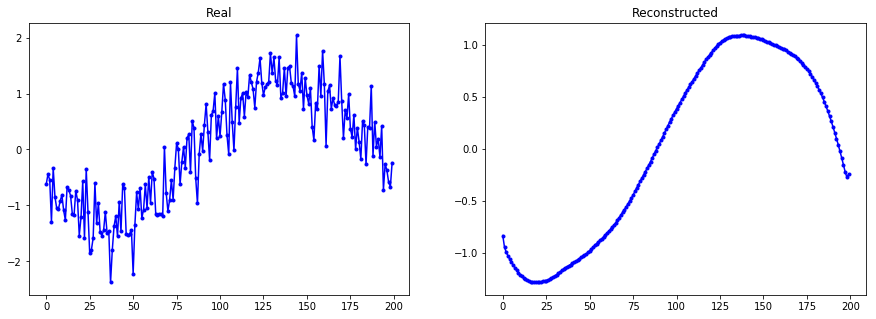

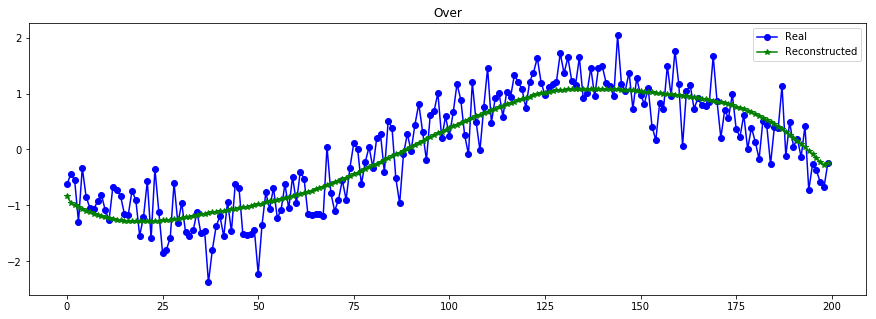

----------------------------------------------------------------


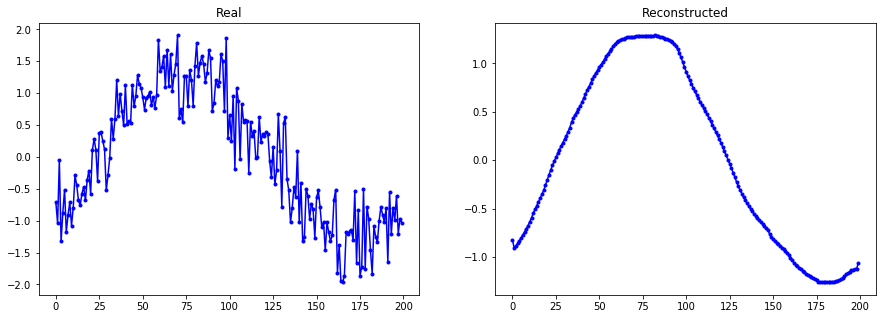

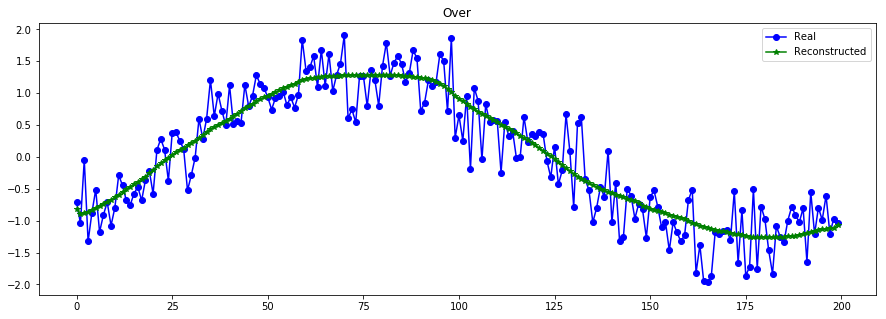

----------------------------------------------------------------


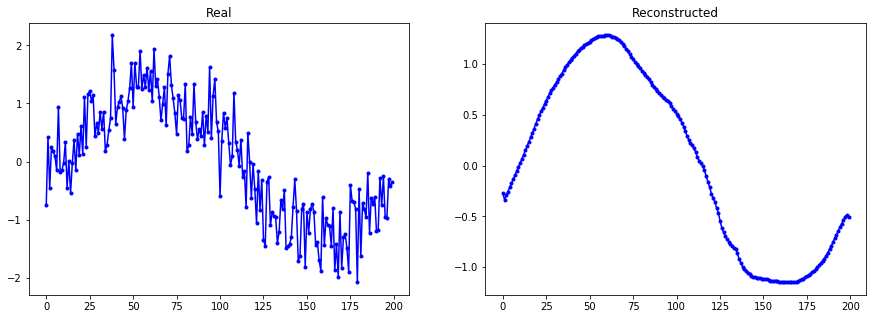

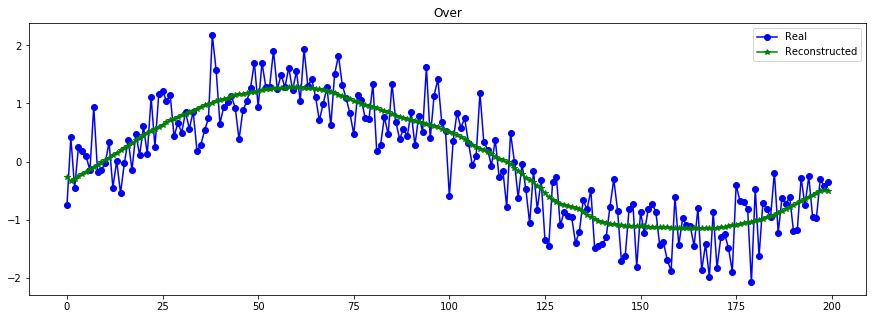

----------------------------------------------------------------


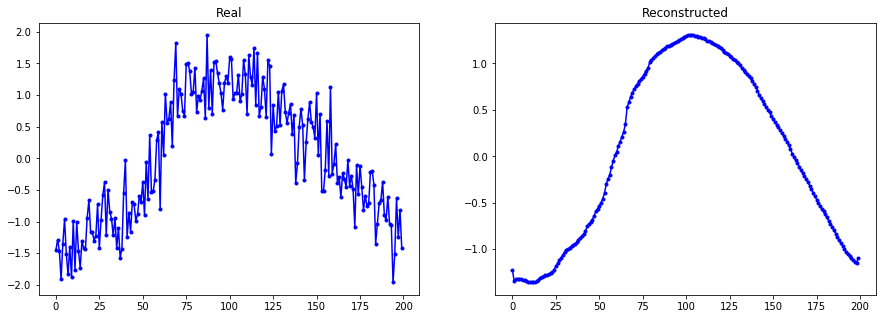

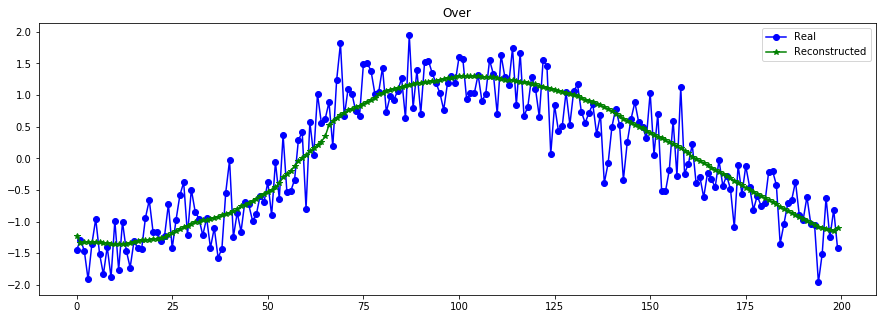

----------------------------------------------------------------


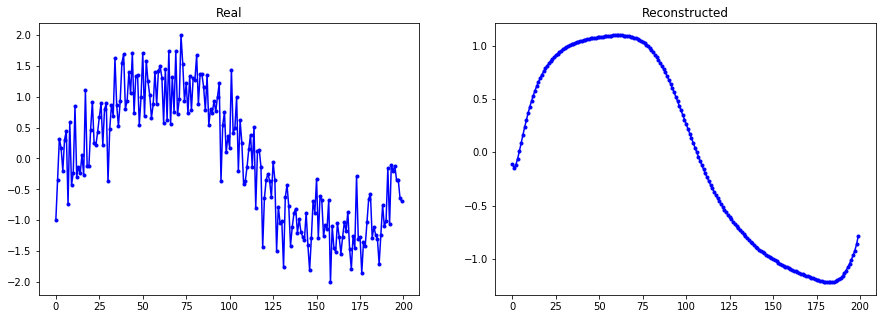

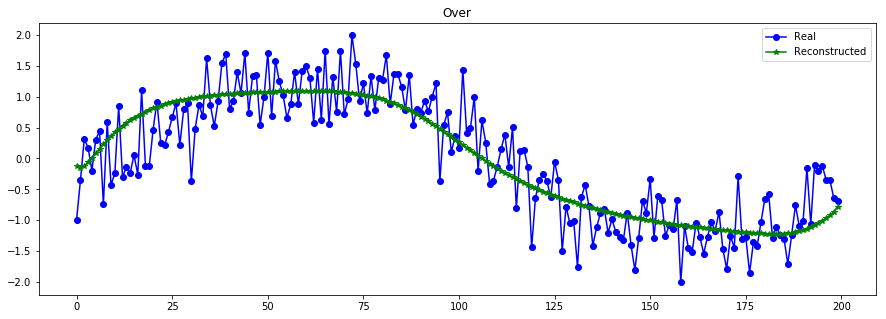

----------------------------------------------------------------


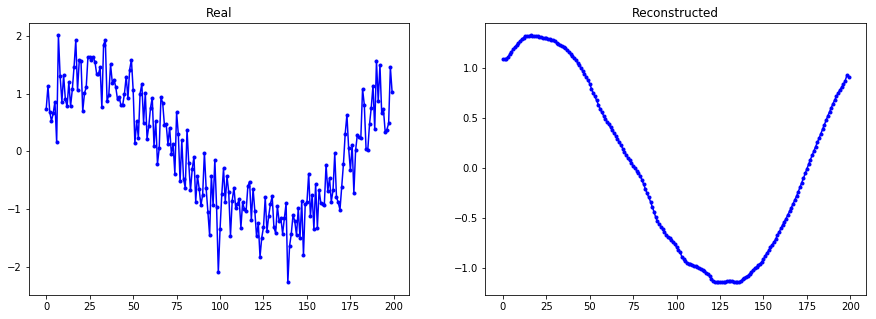

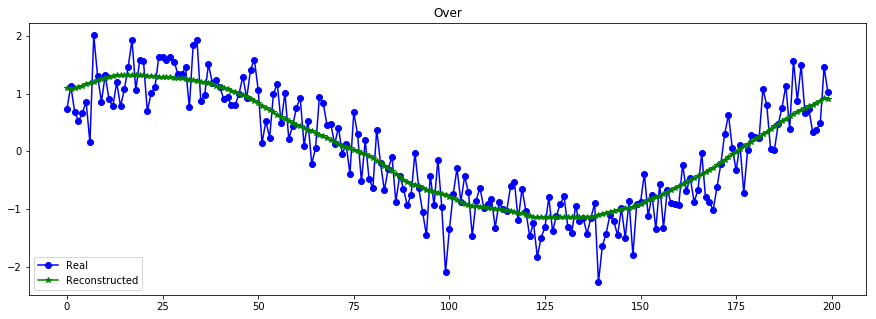

----------------------------------------------------------------


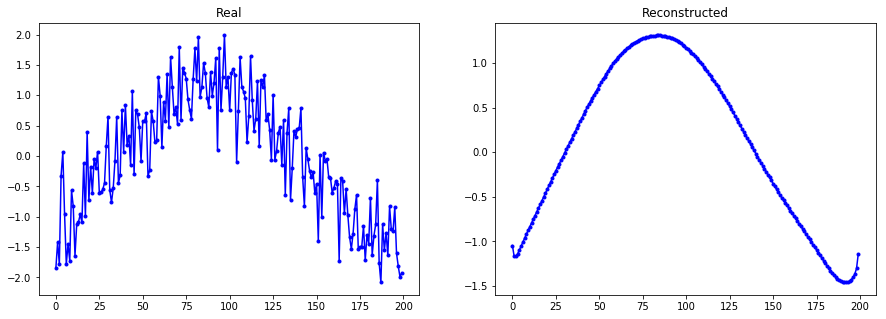

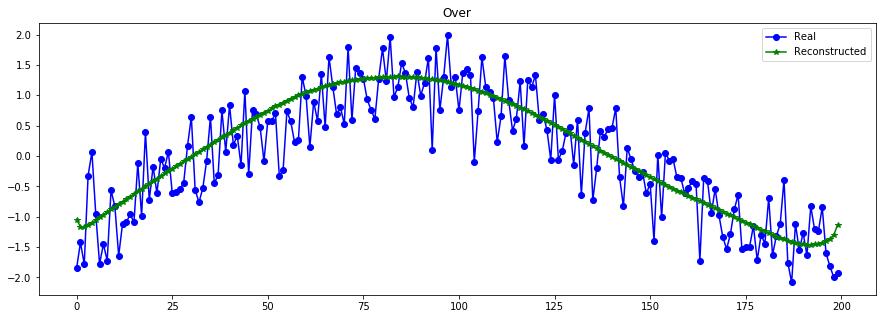

----------------------------------------------------------------


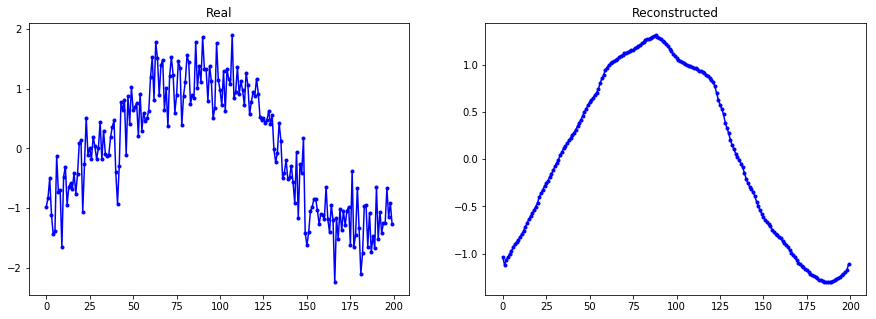

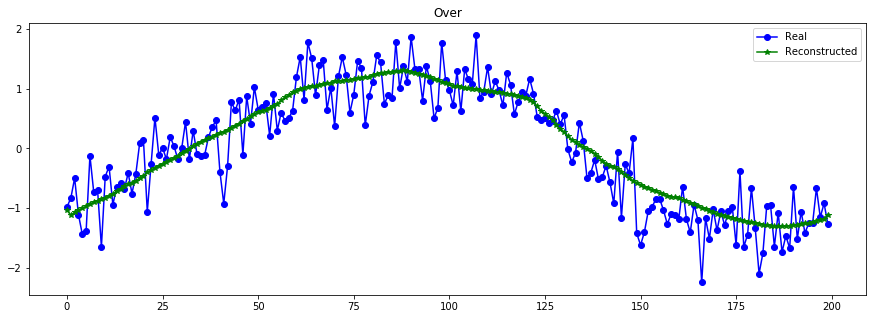

----------------------------------------------------------------


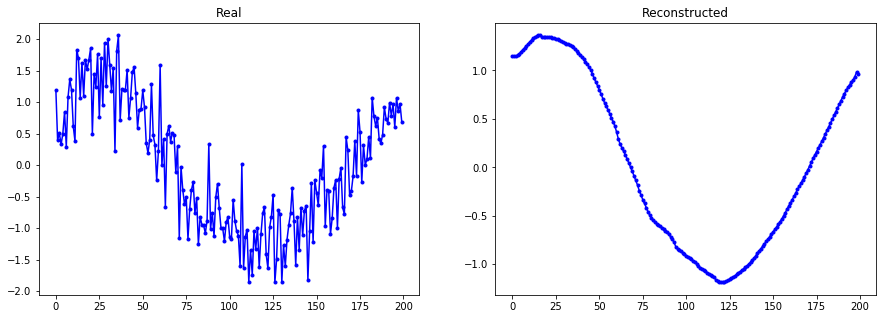

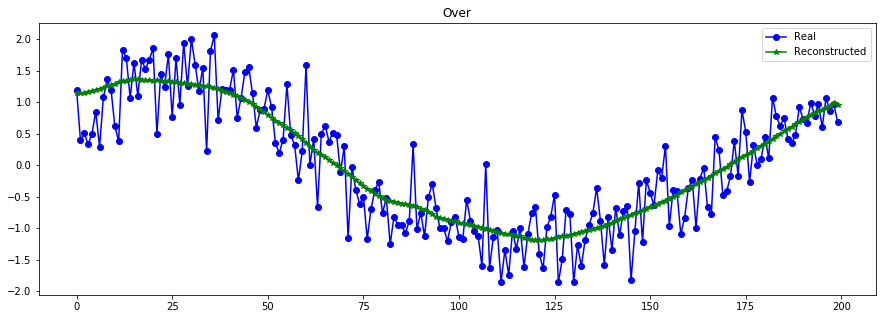

----------------------------------------------------------------


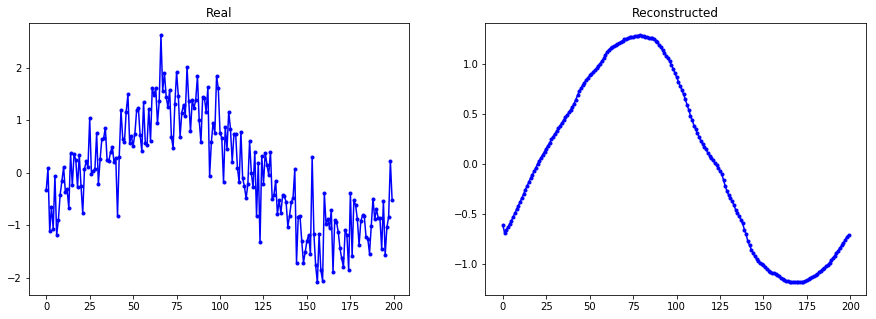

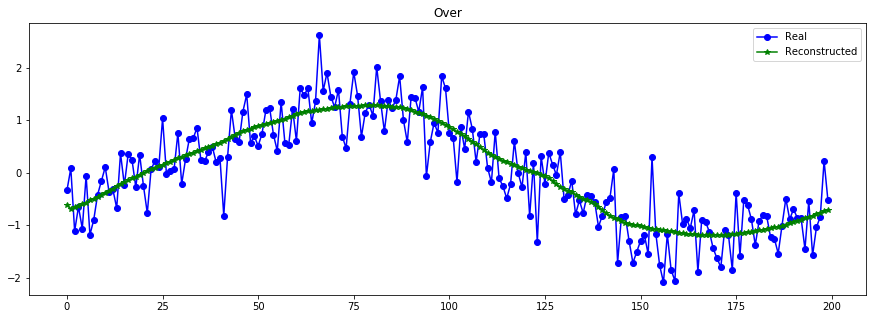

----------------------------------------------------------------


In [25]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

### Global view (even sampled time)

In [40]:
batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=10, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

Train on 712 samples, validate on 288 samples
Epoch 1/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0539 - val_loss: 0.0561
Epoch 2/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0541 - val_loss: 0.0701
Epoch 3/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0647 - val_loss: 0.0549
Epoch 4/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0649 - val_loss: 0.0700
Epoch 5/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0677 - val_loss: 0.0847
Epoch 6/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0597 - val_loss: 0.0526
Epoch 7/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0511 - val_loss: 0.0570
Epoch 8/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0515 - val_loss: 0.0732
Epoch 9/10
712/712 [==============================] - 1s 2ms/step - loss: 0.0745 - val_loss: 0.0731
Epoch 10/10
712/712 [==============================] -

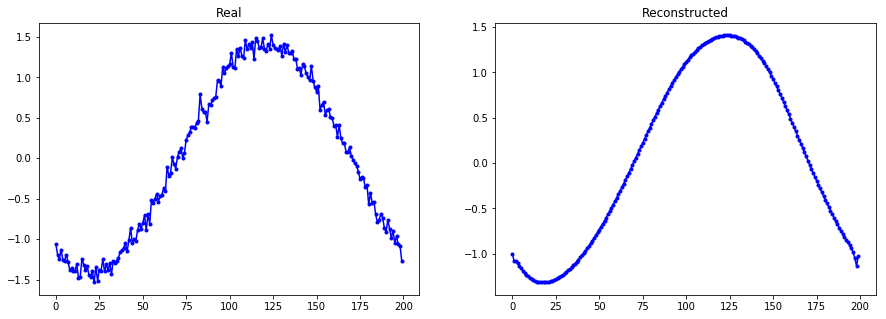

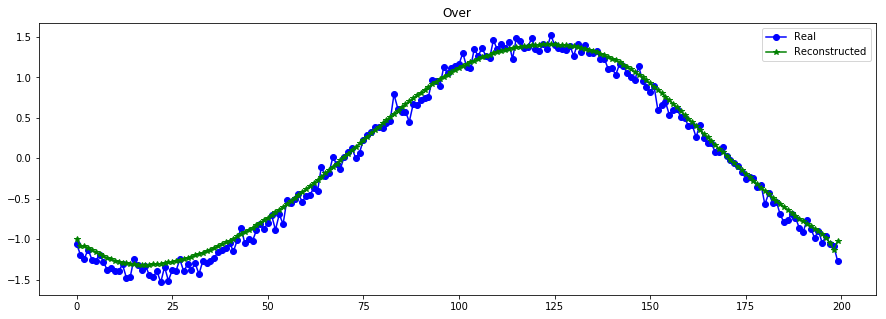

----------------------------------------------------------------


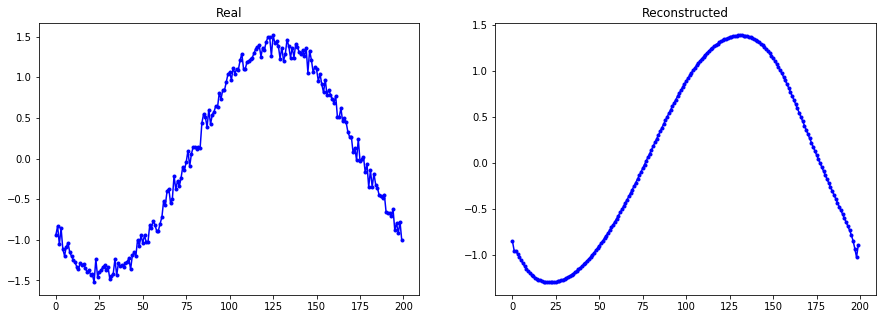

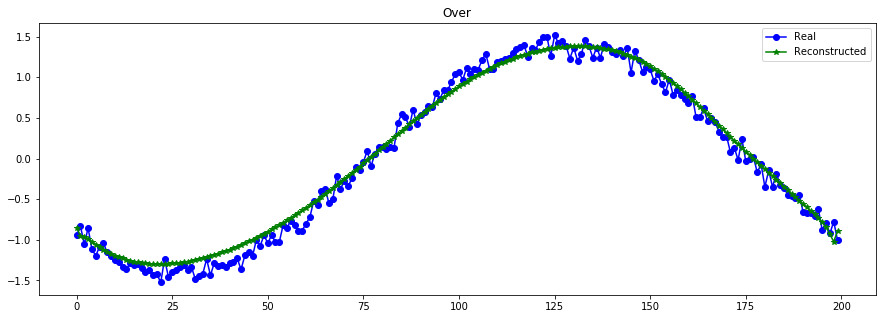

----------------------------------------------------------------


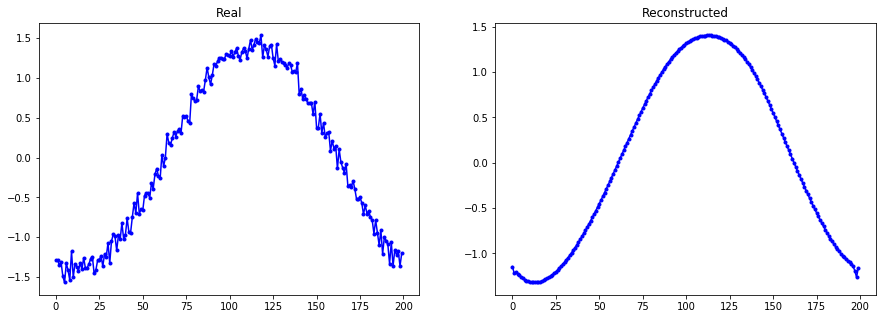

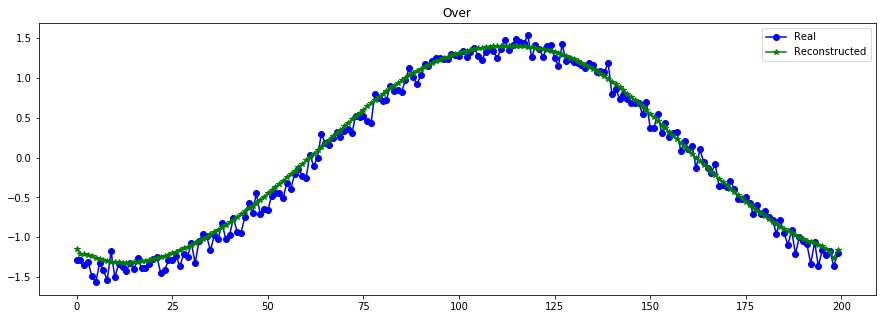

----------------------------------------------------------------


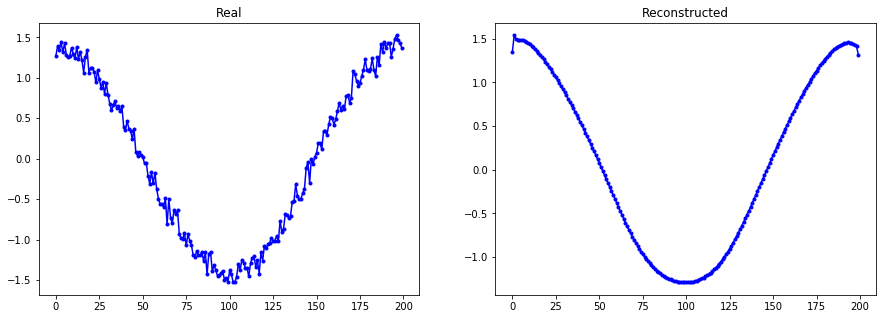

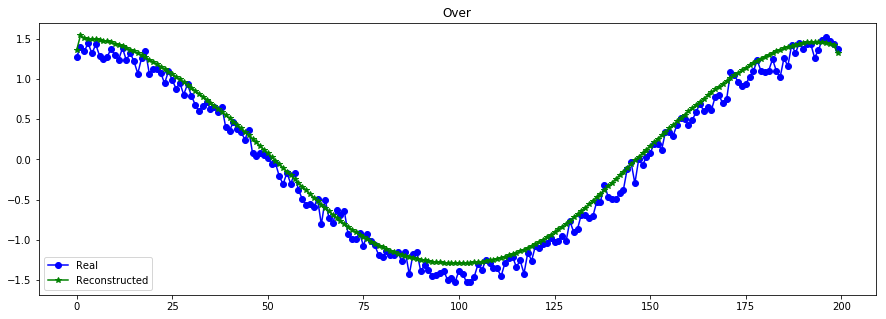

----------------------------------------------------------------


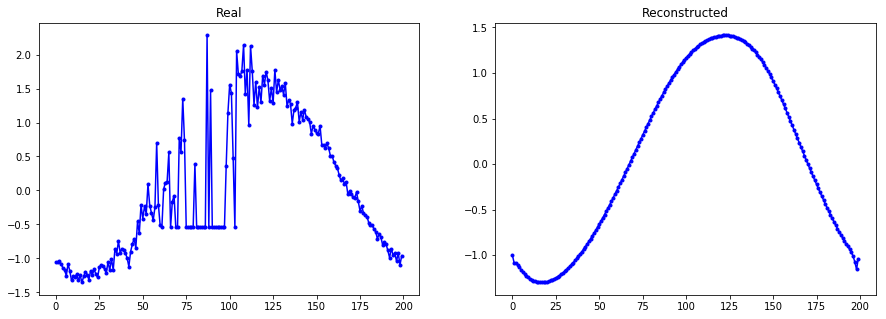

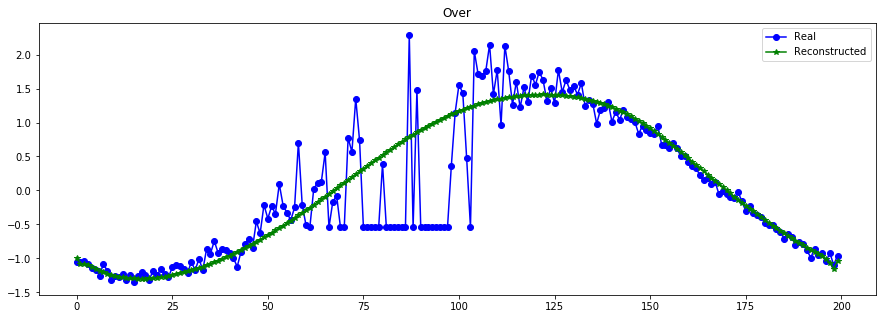

----------------------------------------------------------------


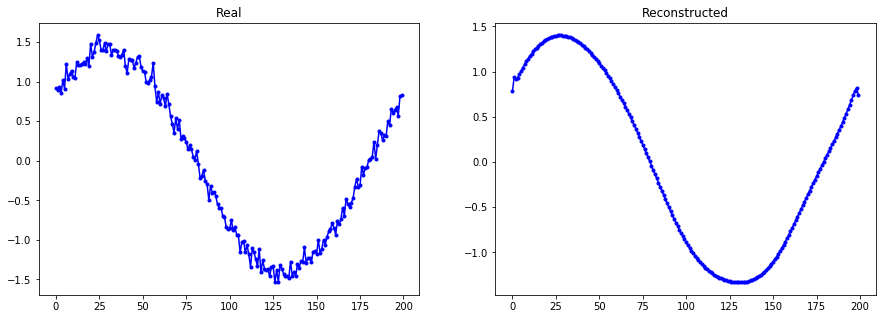

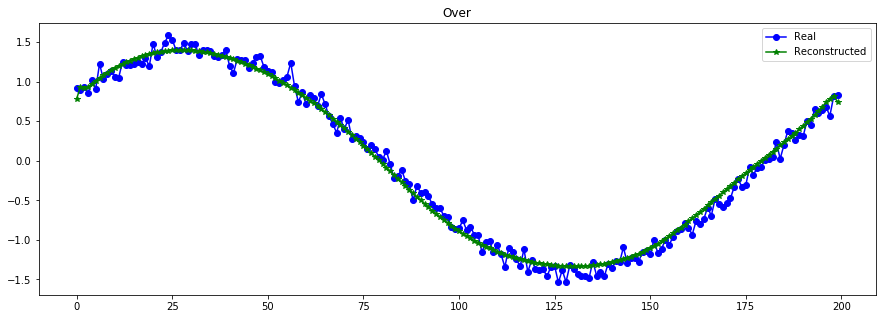

----------------------------------------------------------------


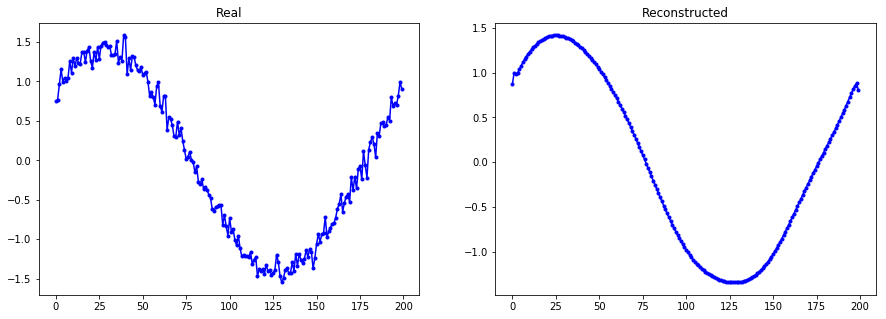

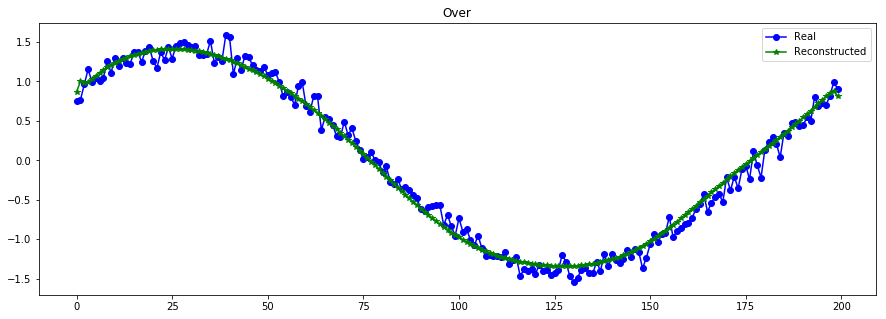

----------------------------------------------------------------


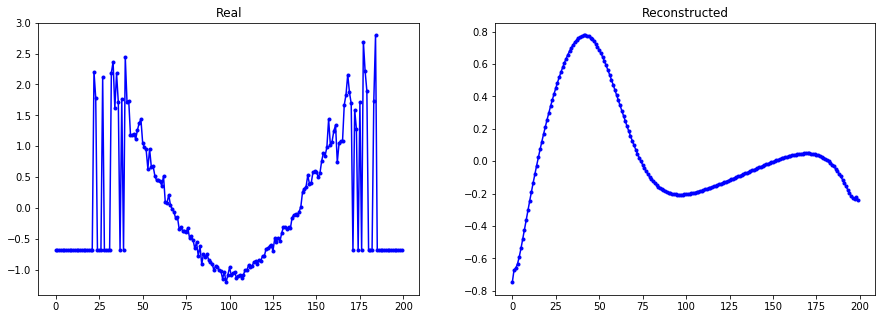

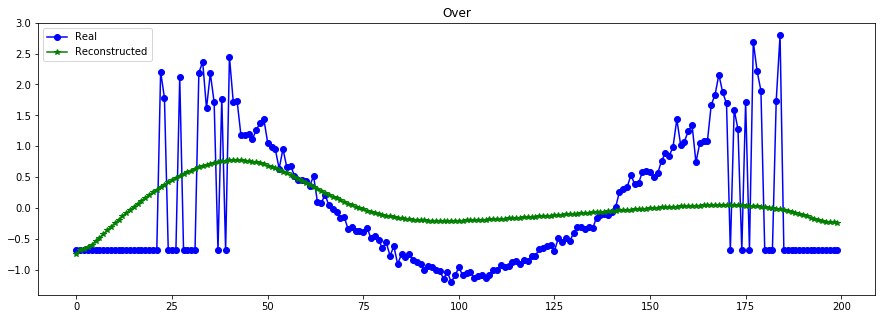

----------------------------------------------------------------


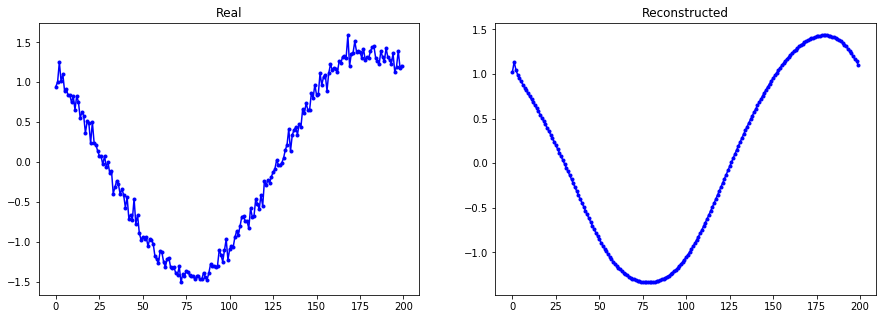

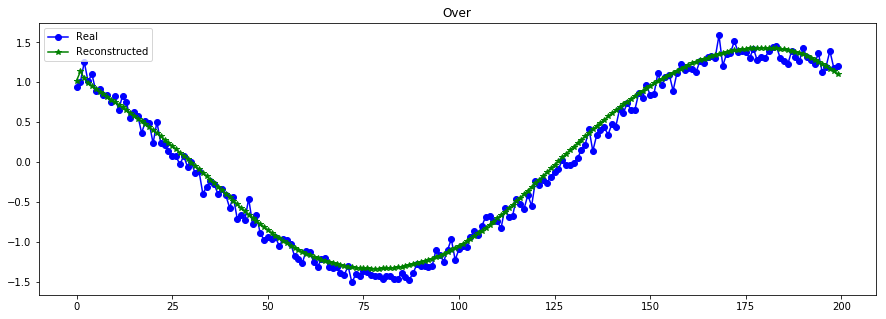

----------------------------------------------------------------


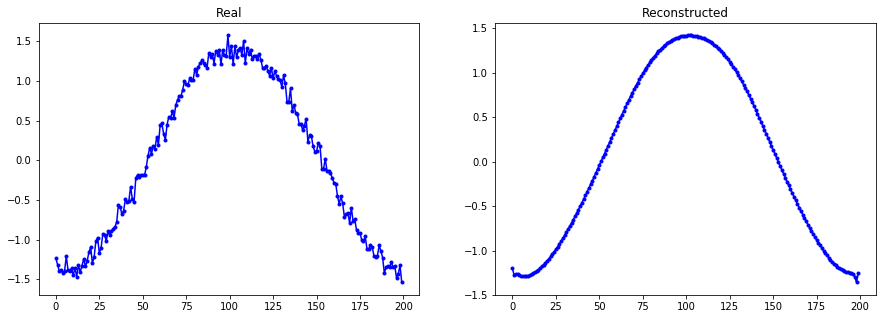

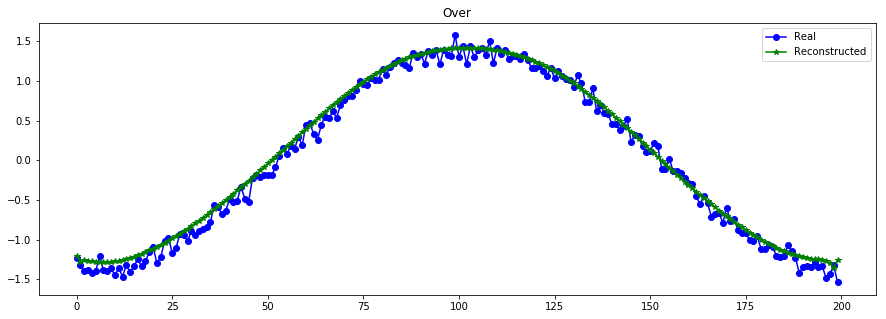

----------------------------------------------------------------


In [41]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

* Aumentar/reducir secuencias (se mantiene hasta mil)
* Probar dropa
* Probar sin el tiempo.. (funciona si las curvas son equispaciadas, pero iwal la diferencia de tiempo entre ellas varia)

In [294]:

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_var) * epsilon

def KL_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(y_true, y_pred):
    l = 0.1 #0.01 #kl weight
    return SSE_loss(y_true, y_pred) + l*KL_loss(y_true, y_pred)

In [295]:
## secuencias largo 500
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(CuDNNGRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(CuDNNGRU(64, return_sequences=False))(f1) #bidirectional

#f1 = Dense(D, activation='relu')(f1)

z_mean = Dense(latent_dim, activation='linear')(f1)
z_log_var = Dense(latent_dim, activation='linear')(f1) # so std = 0.5*z_log_var

encoder = Model([x_t, x_lc], z_mean, name="encoder")

z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

#decode = Dense(D, activation='relu')(decoder_input)

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_loss,  metrics = [KL_loss, MSE_loss])

vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 500, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 500, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 16)           104736      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 500, 1)       106497      T_inp[0][0]                      
          

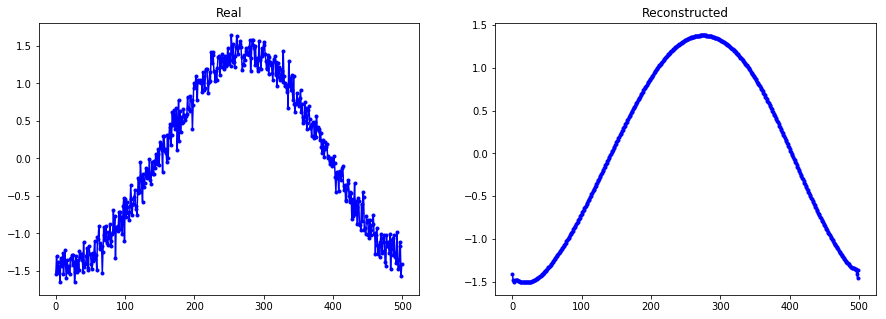

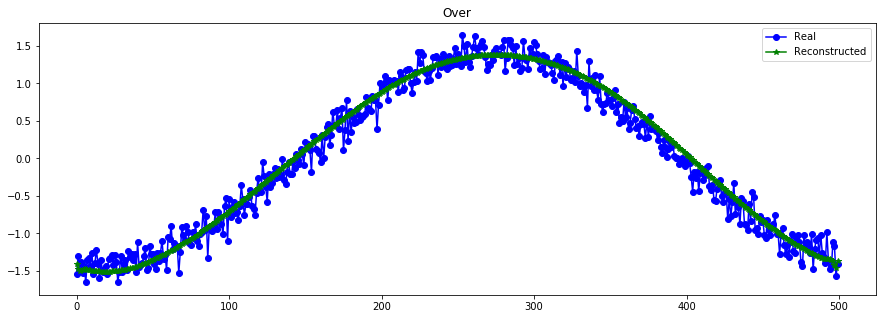

----------------------------------------------------------------


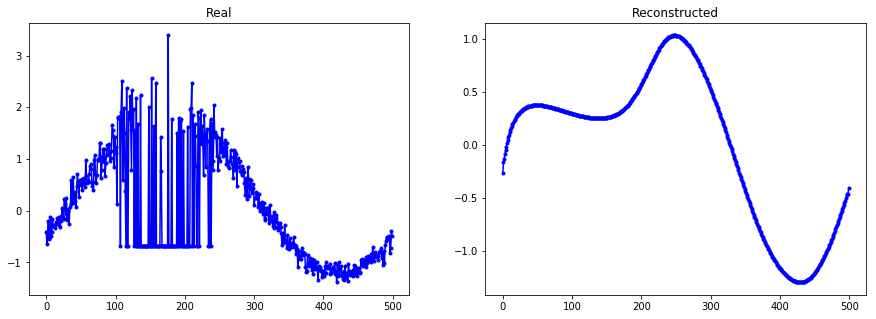

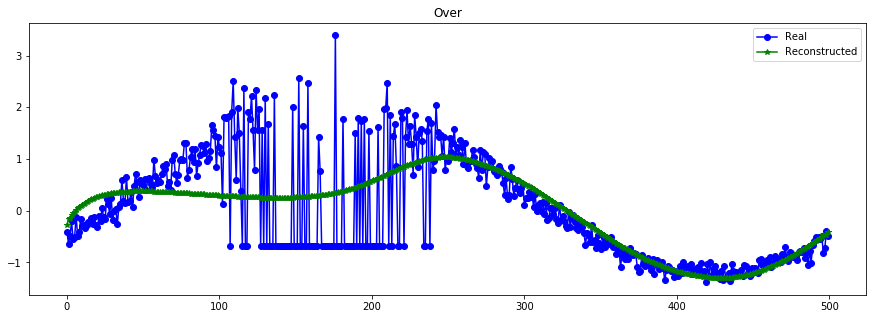

----------------------------------------------------------------


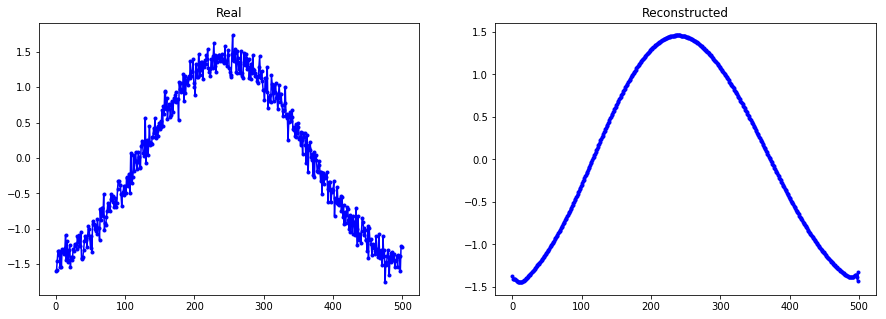

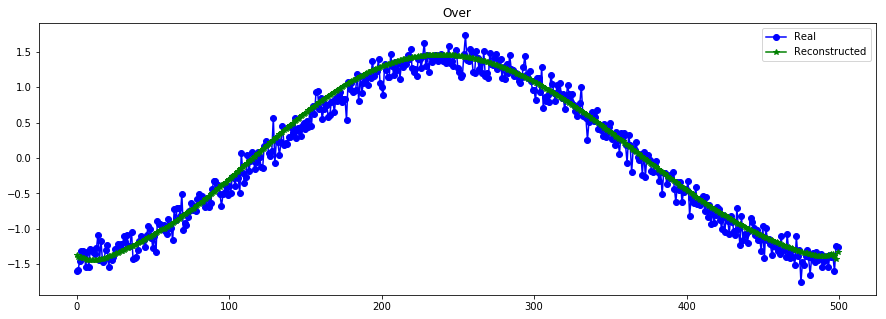

----------------------------------------------------------------


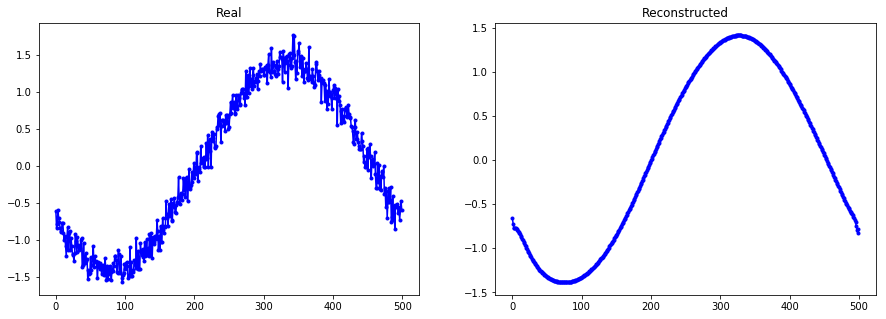

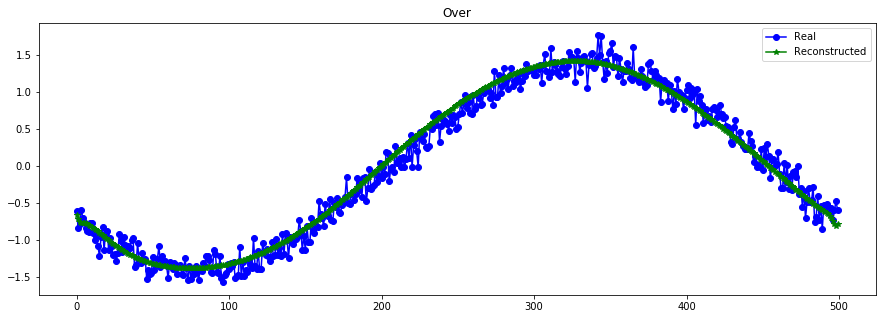

----------------------------------------------------------------


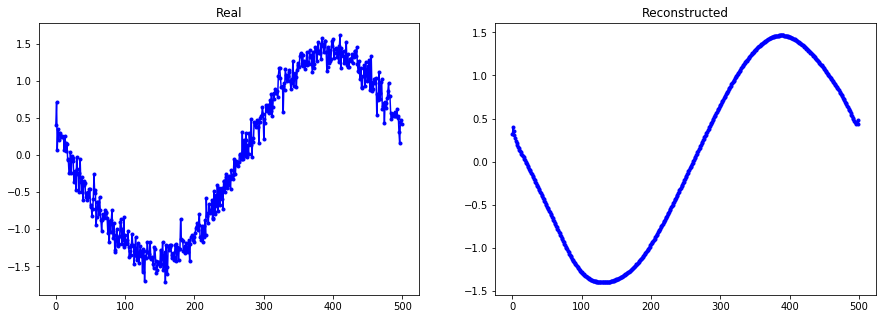

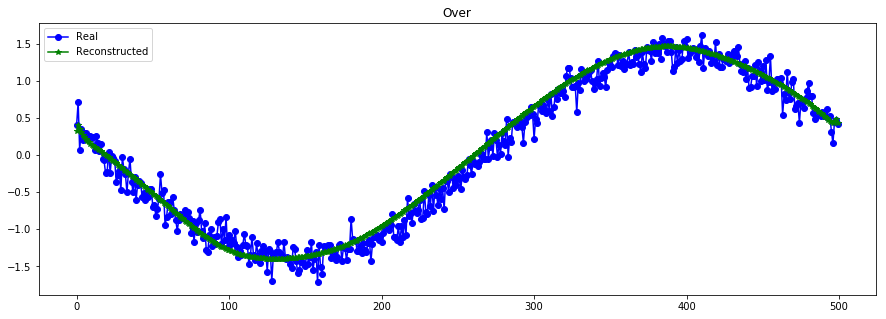

----------------------------------------------------------------


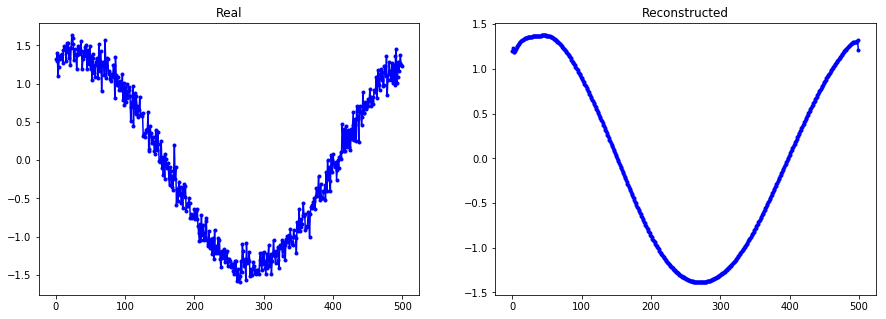

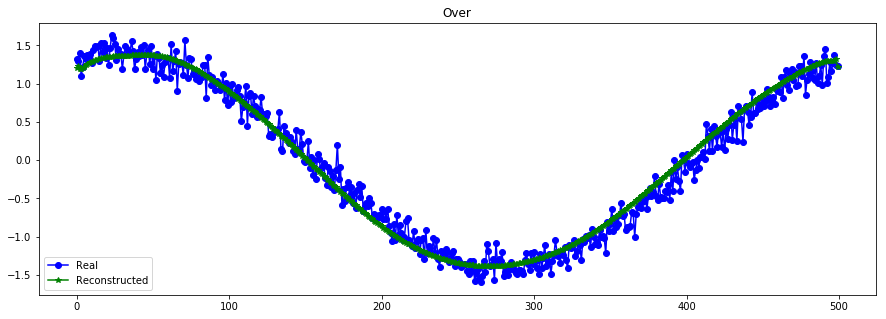

----------------------------------------------------------------


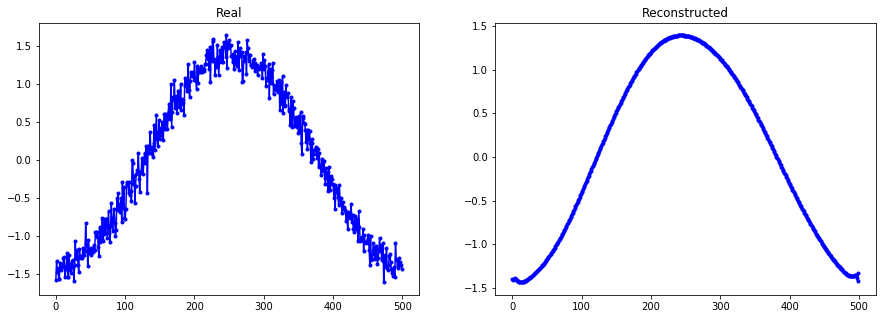

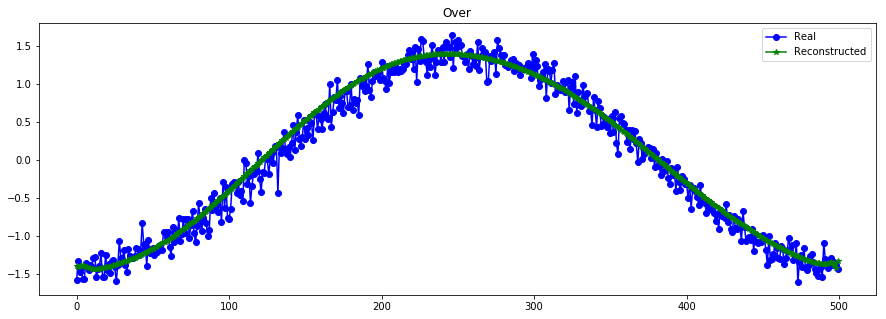

----------------------------------------------------------------


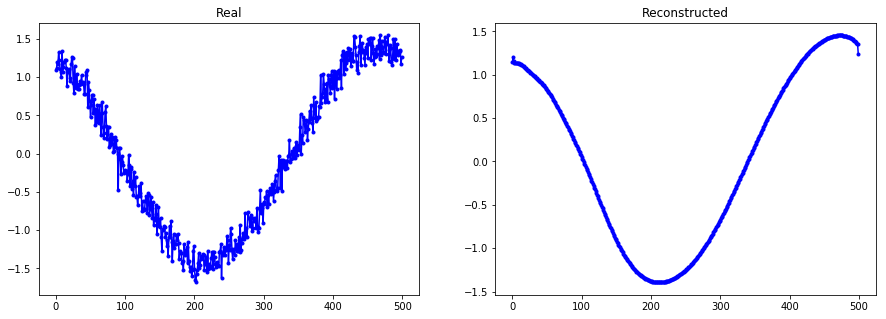

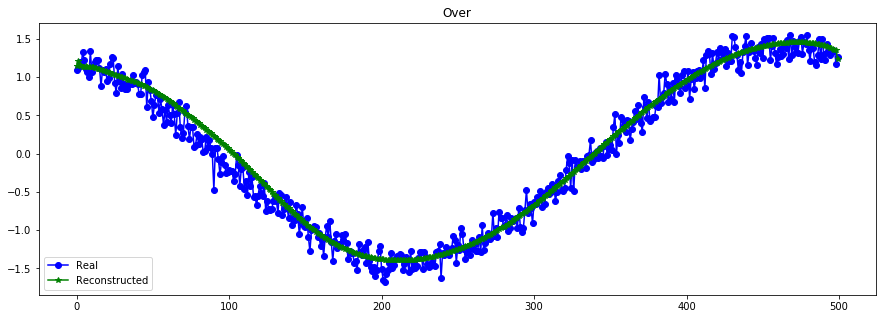

----------------------------------------------------------------


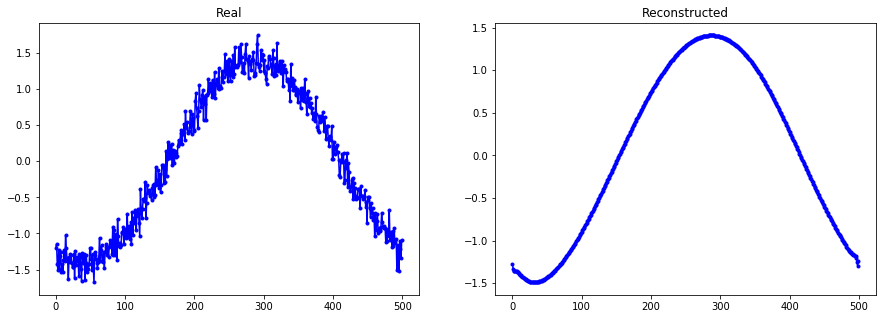

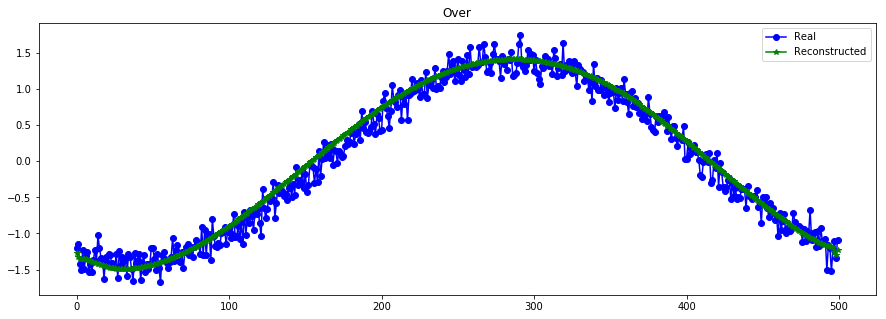

----------------------------------------------------------------


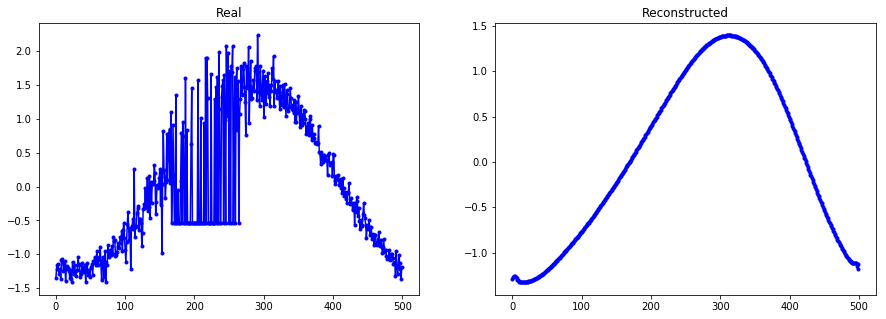

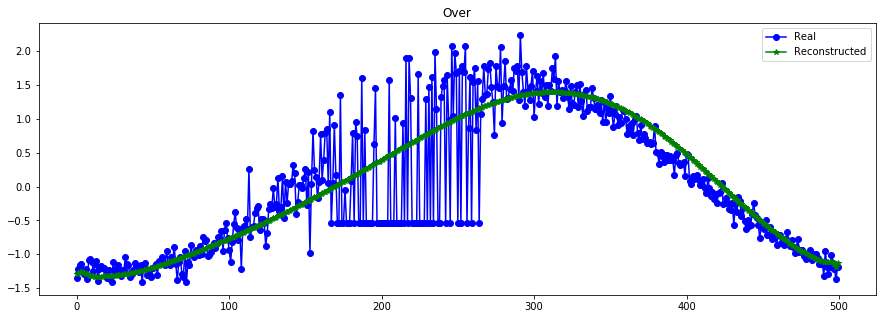

----------------------------------------------------------------


In [296]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [301]:
## secuencias largo 100
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(CuDNNGRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(CuDNNGRU(64, return_sequences=False))(f1) #bidirectional

#f1 = Dense(D, activation='relu')(f1)

z_mean = Dense(latent_dim, activation='linear')(f1)
z_log_var = Dense(latent_dim, activation='linear')(f1) # so std = 0.5*z_log_var

encoder = Model([x_t, x_lc], z_mean, name="encoder")

z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

#decode = Dense(D, activation='relu')(decoder_input)

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_loss,  metrics = [KL_loss, MSE_loss])

vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 100, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 100, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 16)           104736      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 100, 1)       106497      T_inp[0][0]                      
          

Epoch 37/50
3510/3510 [==============================] - 6s 2ms/step - loss: 4.0834 - KL_loss: 11.5265 - MSE_loss: 0.0293 - val_loss: 4.2287 - val_KL_loss: 11.6309 - val_MSE_loss: 0.0307
Epoch 38/50
3510/3510 [==============================] - 6s 2ms/step - loss: 4.1846 - KL_loss: 11.0680 - MSE_loss: 0.0308 - val_loss: 5.3807 - val_KL_loss: 11.7148 - val_MSE_loss: 0.0421
Epoch 39/50
3510/3510 [==============================] - 5s 2ms/step - loss: 4.9068 - KL_loss: 12.6445 - MSE_loss: 0.0364 - val_loss: 4.2810 - val_KL_loss: 11.6334 - val_MSE_loss: 0.0312
Epoch 40/50
3510/3510 [==============================] - 6s 2ms/step - loss: 4.0567 - KL_loss: 11.0910 - MSE_loss: 0.0295 - val_loss: 4.5074 - val_KL_loss: 11.2956 - val_MSE_loss: 0.0338
Epoch 41/50
3510/3510 [==============================] - 6s 2ms/step - loss: 4.1997 - KL_loss: 11.0868 - MSE_loss: 0.0309 - val_loss: 4.1855 - val_KL_loss: 10.7039 - val_MSE_loss: 0.0312
Epoch 42/50
3510/3510 [==============================] - 6s 2ms/s

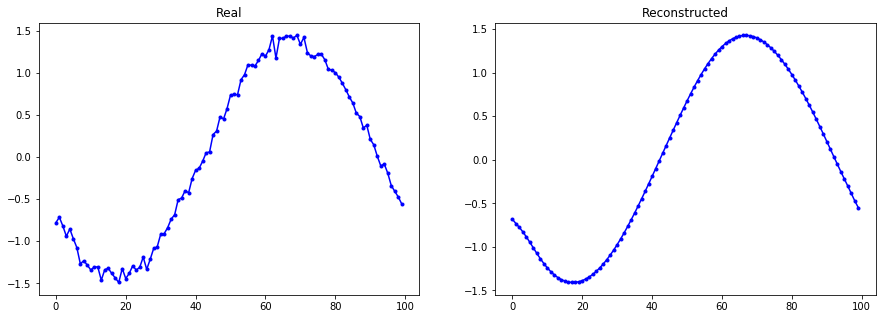

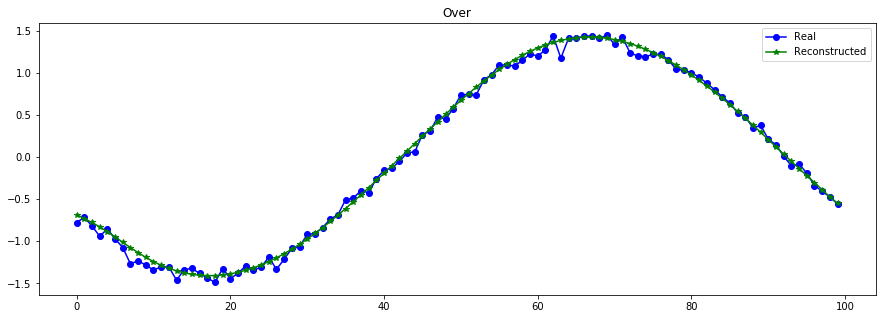

----------------------------------------------------------------


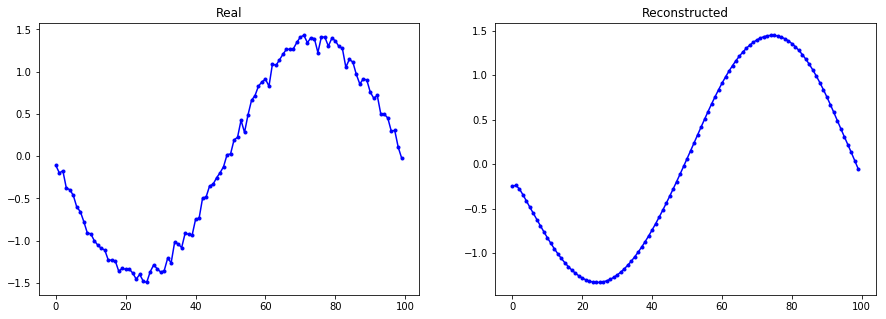

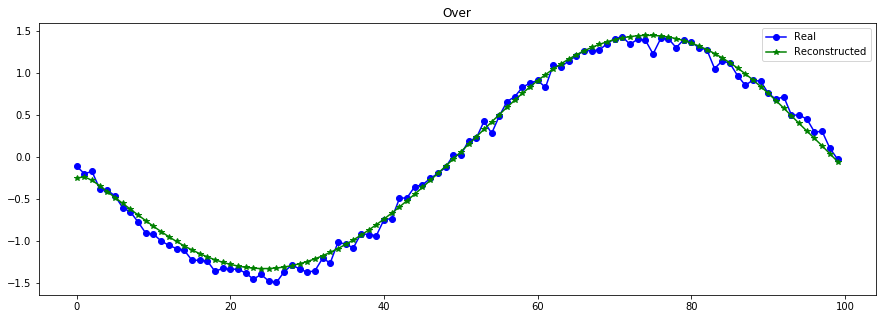

----------------------------------------------------------------


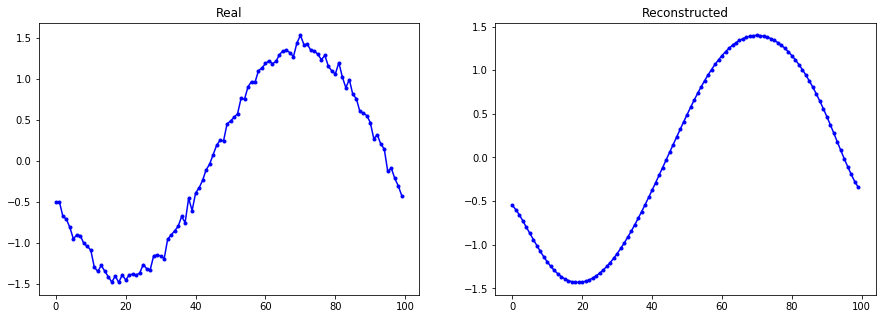

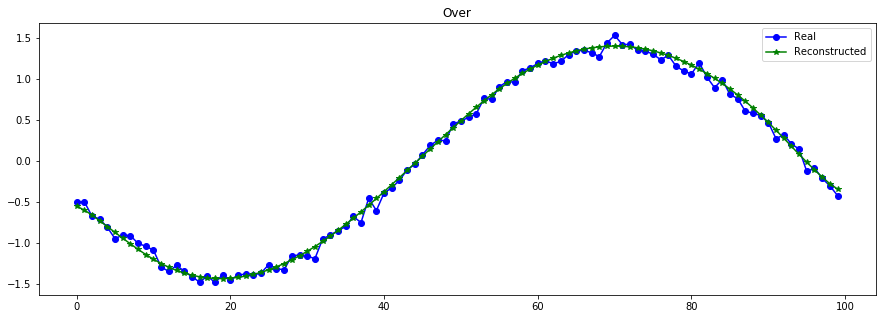

----------------------------------------------------------------


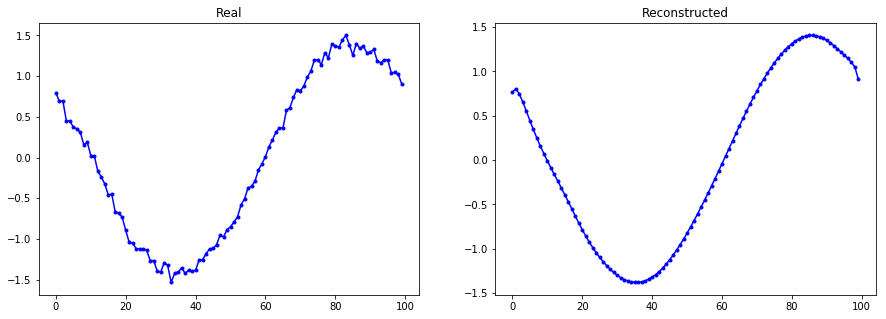

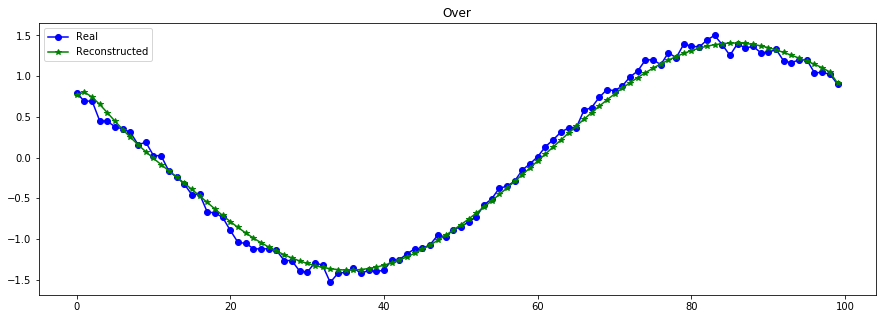

----------------------------------------------------------------


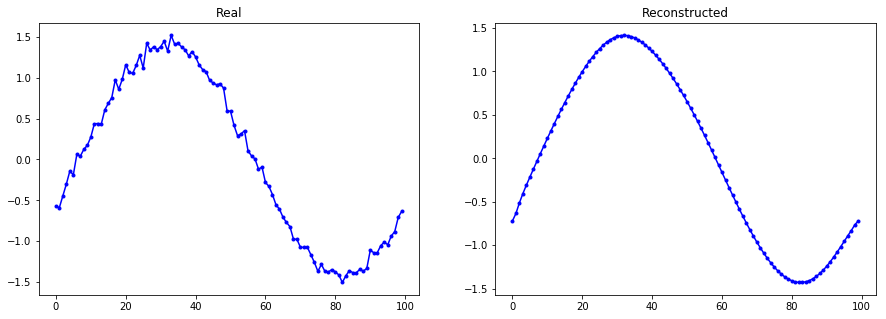

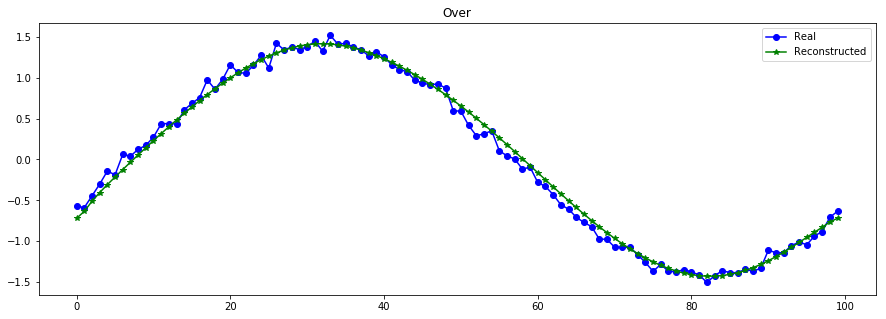

----------------------------------------------------------------


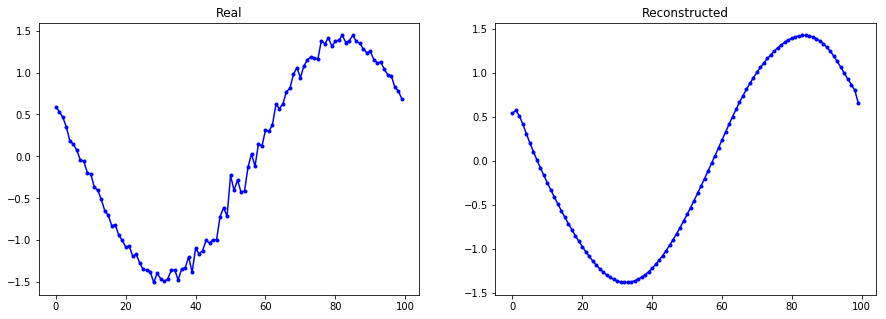

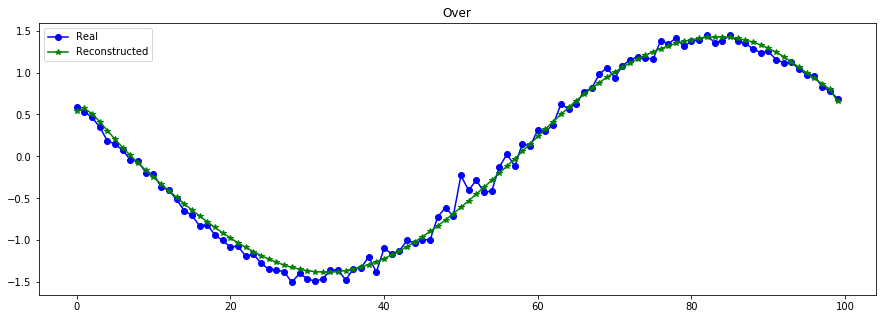

----------------------------------------------------------------


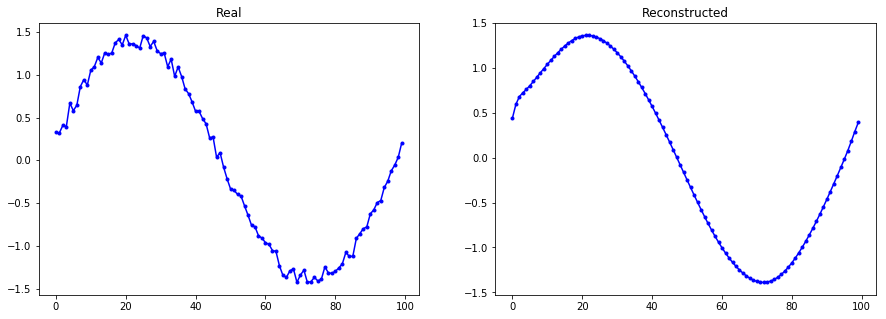

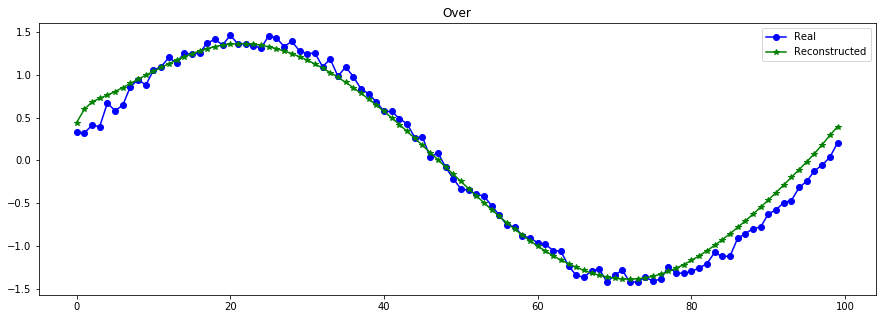

----------------------------------------------------------------


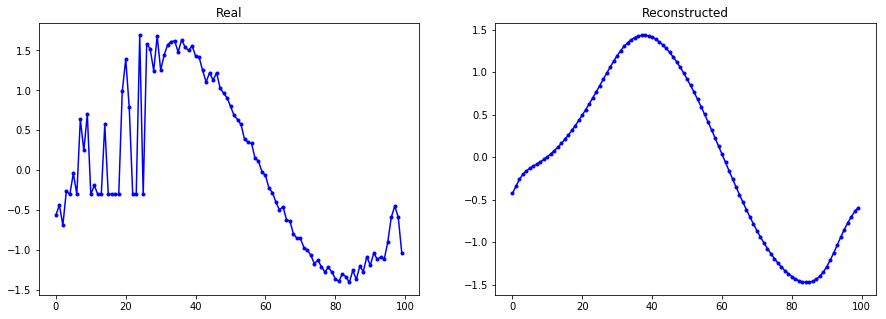

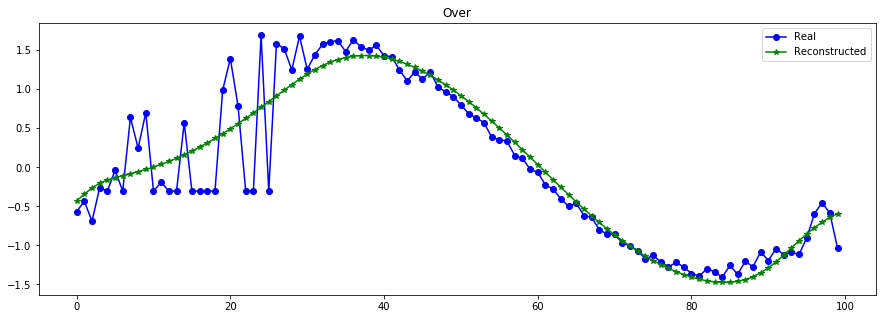

----------------------------------------------------------------


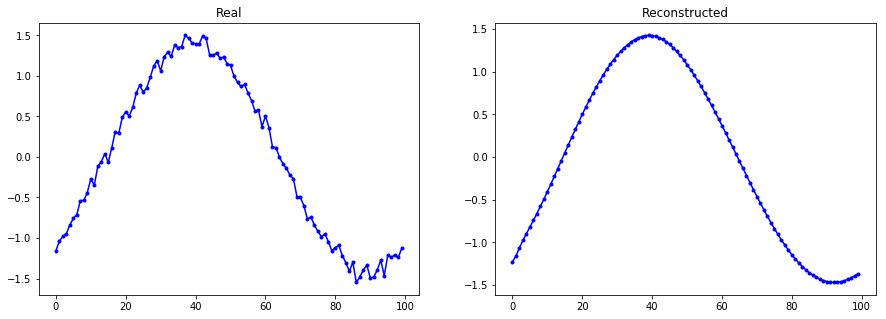

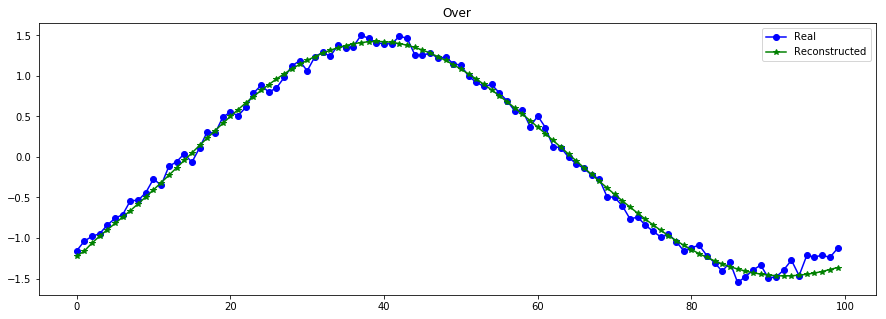

----------------------------------------------------------------


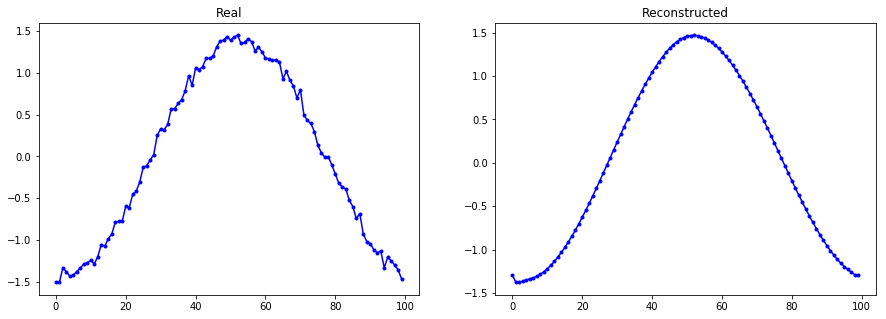

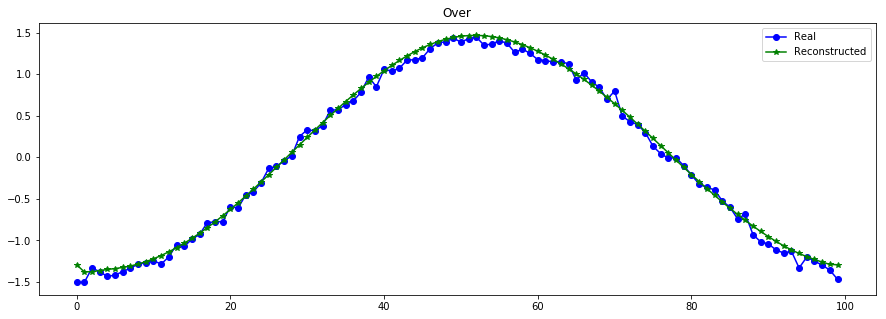

----------------------------------------------------------------


In [302]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [306]:
## secuencias largo 1000
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(CuDNNGRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(CuDNNGRU(64, return_sequences=False))(f1) #bidirectional

#f1 = Dense(D, activation='relu')(f1)

z_mean = Dense(latent_dim, activation='linear')(f1)
z_log_var = Dense(latent_dim, activation='linear')(f1) # so std = 0.5*z_log_var

encoder = Model([x_t, x_lc], z_mean, name="encoder")

z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

#decode = Dense(D, activation='relu')(decoder_input)

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_loss,  metrics = [KL_loss, MSE_loss])

vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 16)           104736      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 1000, 1)      106497      T_inp[0][0]                      
          

Epoch 36/50
3448/3448 [==============================] - 38s 11ms/step - loss: 91.9272 - KL_loss: 68.3554 - MSE_loss: 0.0851 - val_loss: 90.6483 - val_KL_loss: 68.2306 - val_MSE_loss: 0.0838
Epoch 37/50
3448/3448 [==============================] - 38s 11ms/step - loss: 93.2294 - KL_loss: 68.8111 - MSE_loss: 0.0863 - val_loss: 87.5237 - val_KL_loss: 68.5922 - val_MSE_loss: 0.0807
Epoch 38/50
3448/3448 [==============================] - 38s 11ms/step - loss: 89.2316 - KL_loss: 67.7154 - MSE_loss: 0.0825 - val_loss: 90.2117 - val_KL_loss: 66.7051 - val_MSE_loss: 0.0835
Epoch 39/50
3448/3448 [==============================] - 38s 11ms/step - loss: 87.2194 - KL_loss: 66.0550 - MSE_loss: 0.0806 - val_loss: 90.7258 - val_KL_loss: 66.4244 - val_MSE_loss: 0.0841
Epoch 40/50
3448/3448 [==============================] - 38s 11ms/step - loss: 158.6242 - KL_loss: 70.1176 - MSE_loss: 0.1516 - val_loss: 126.8260 - val_KL_loss: 72.1807 - val_MSE_loss: 0.1196
Epoch 41/50
3448/3448 [====================

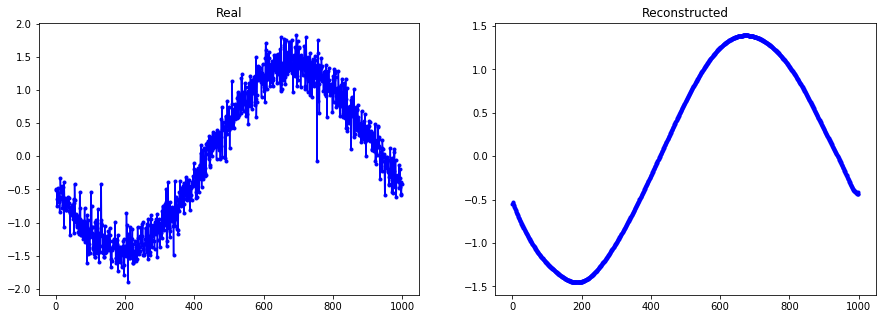

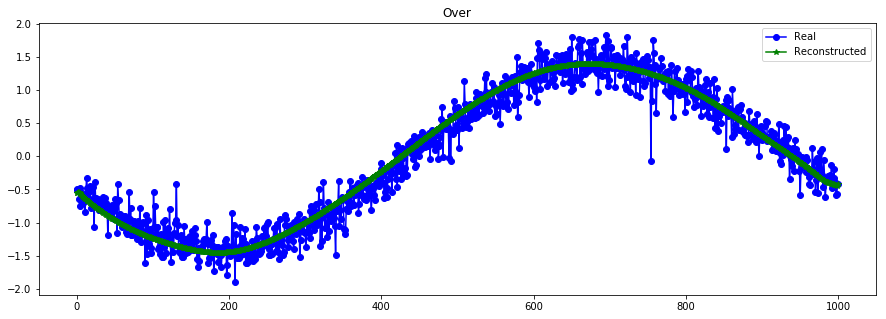

----------------------------------------------------------------


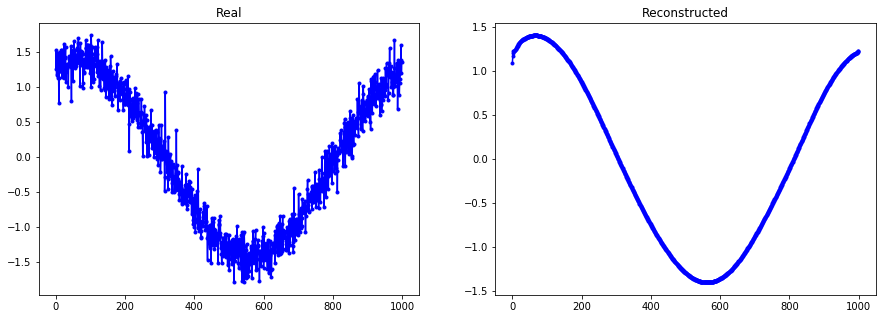

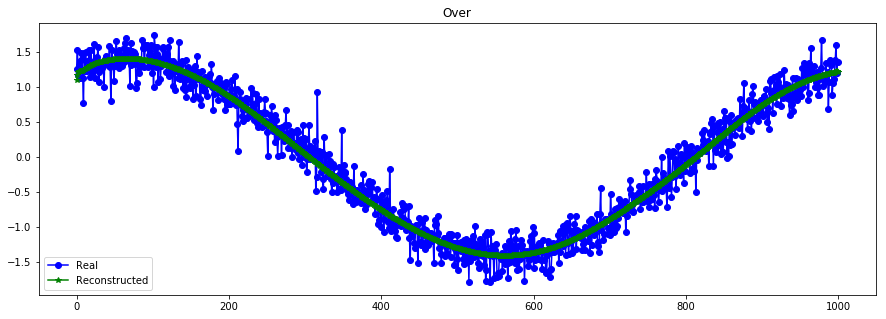

----------------------------------------------------------------


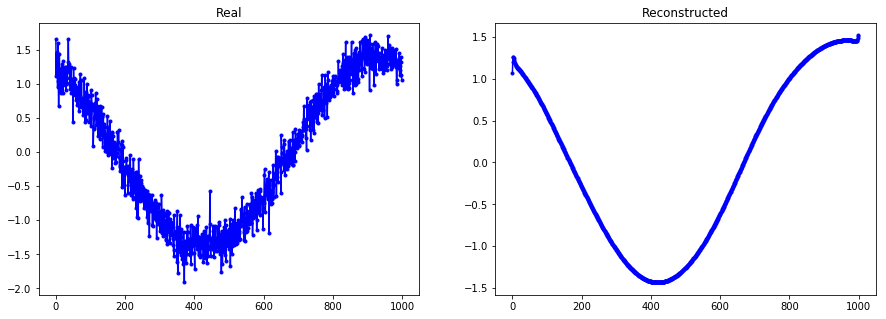

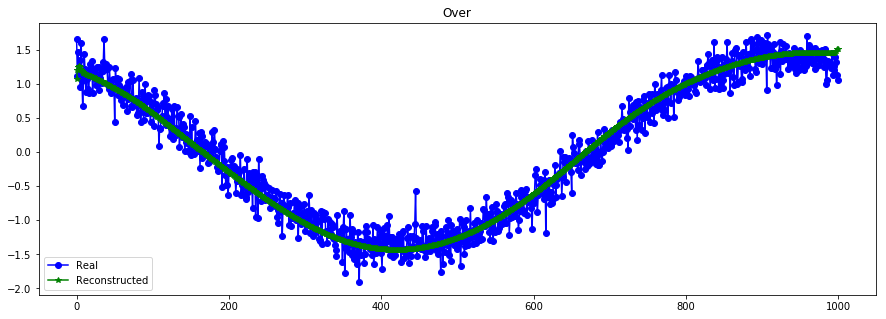

----------------------------------------------------------------


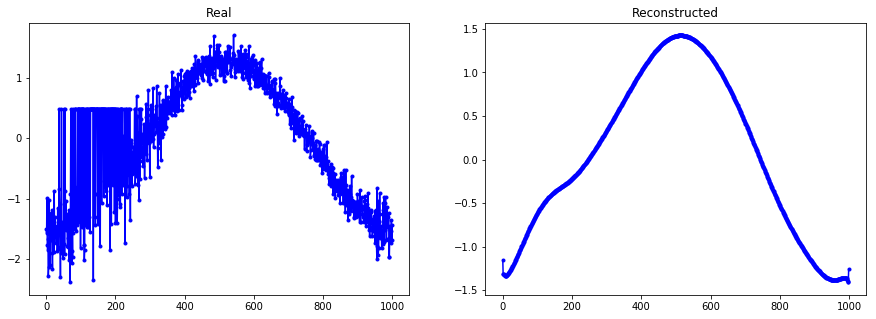

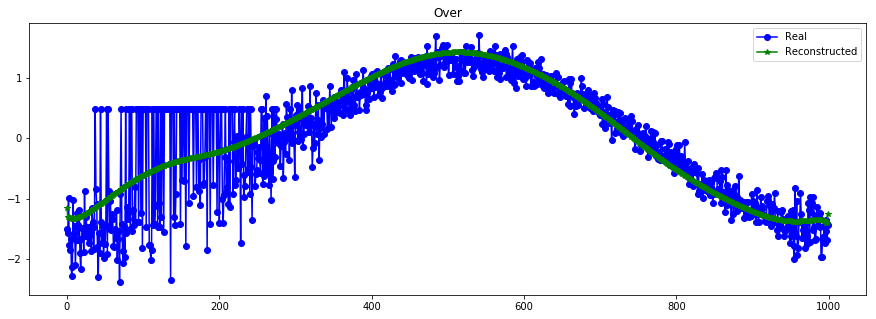

----------------------------------------------------------------


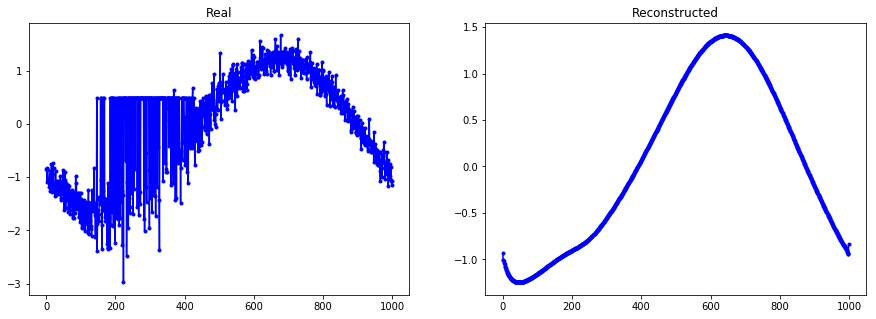

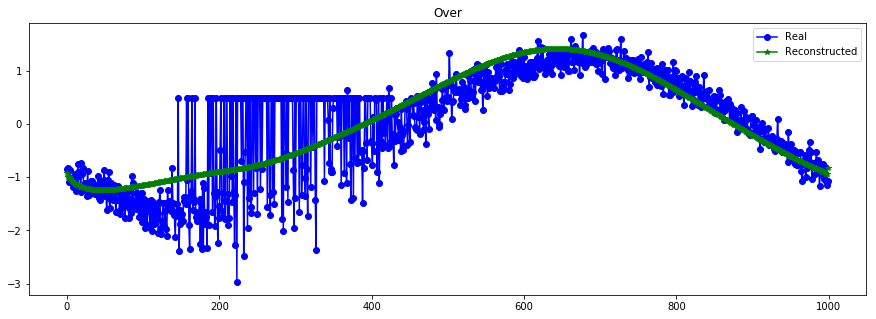

----------------------------------------------------------------


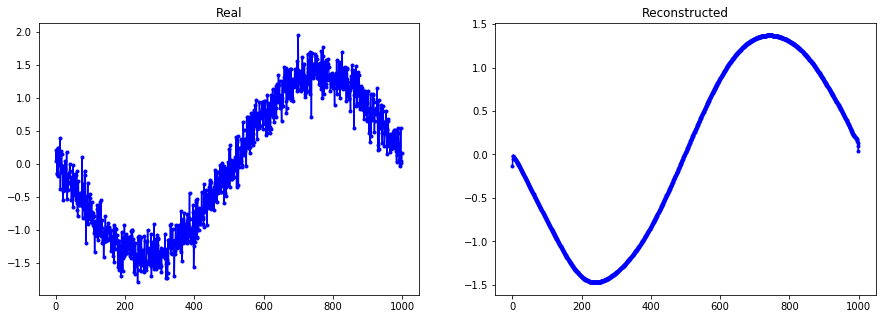

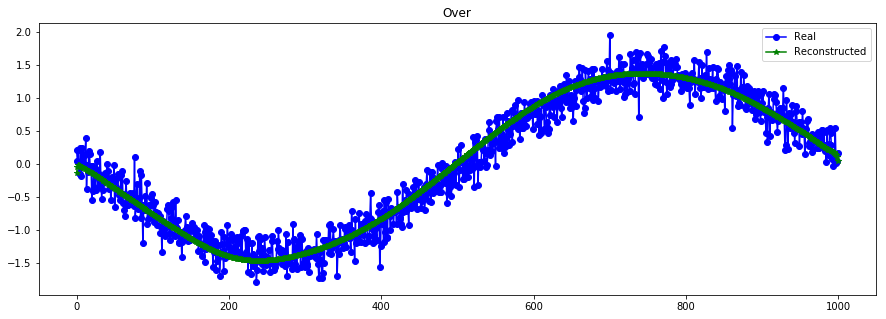

----------------------------------------------------------------


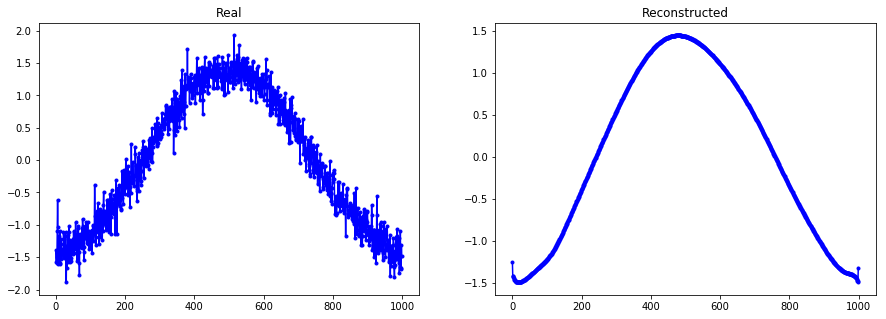

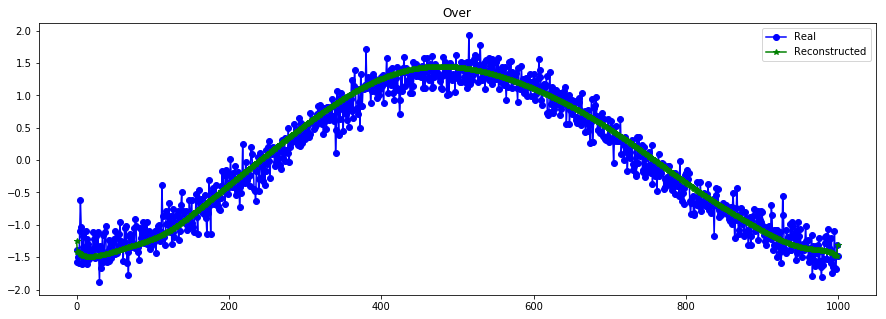

----------------------------------------------------------------


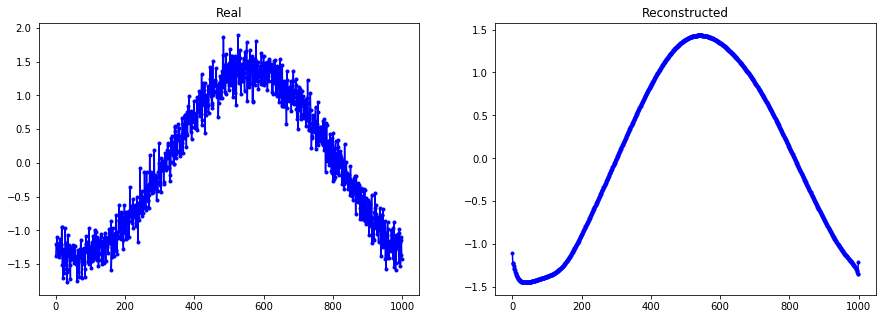

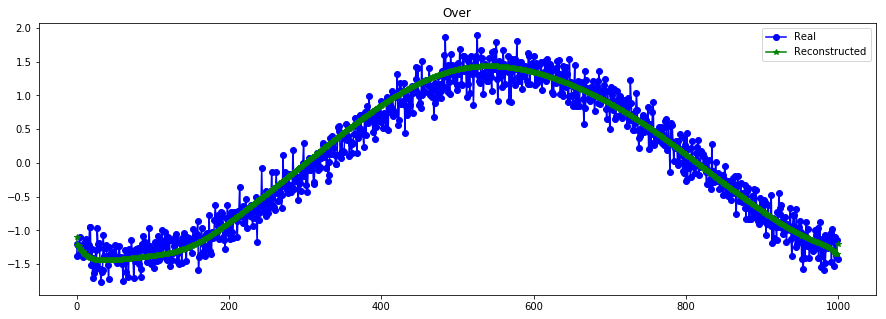

----------------------------------------------------------------


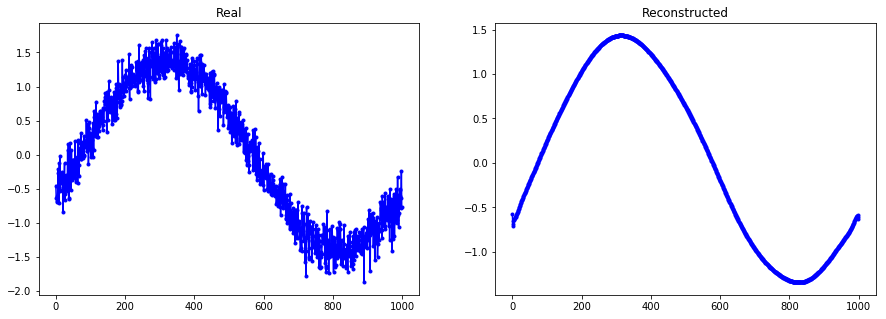

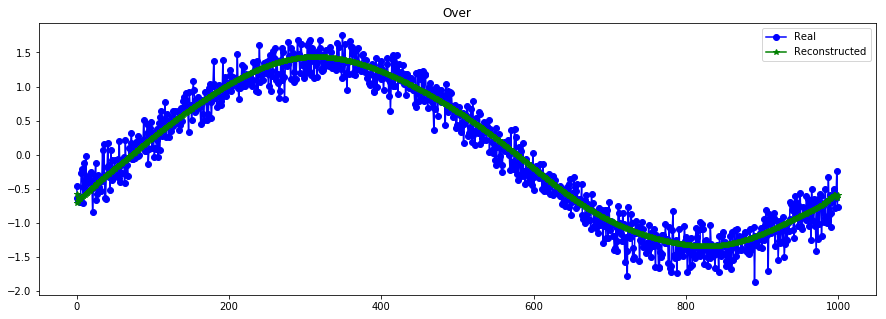

----------------------------------------------------------------


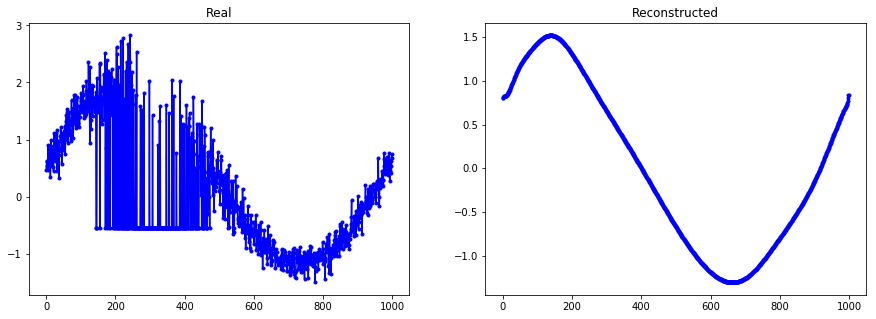

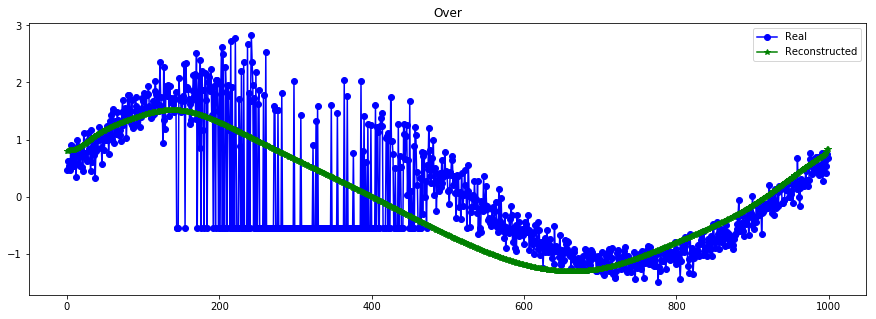

----------------------------------------------------------------


In [307]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [311]:
### sin tiempo
x = Input(shape = (T, channels) )

f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model(x, z_mean, name="encoder")

z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model(x, z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model(decoder_input, decode, name="generator")

# instantiate VAE model
out = generator(samp_encoder(x))
vae = Model(x, out)
vae.compile(optimizer='adam', loss=vae_loss,  metrics = [KL_loss, MSE_loss])
vae.summary()

batch_size = 64
vae.fit(X_train, X_train, epochs=20, batch_size=batch_size, validation_data=(X_test, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        (None, 200, 1)            0         
_________________________________________________________________
encoder_sampling (Model)     (None, 16)                103584    
_________________________________________________________________
generator (Model)            (None, 200, 1)            105345    
Total params: 208,929
Trainable params: 208,929
Non-trainable params: 0
_________________________________________________________________
Train on 3484 samples, validate on 1516 samples
Epoch 1/20
3484/3484 [==============================] - 267s 77ms/step - loss: 195.4903 - KL_loss: 6.1442 - MSE_loss: 0.9744 - val_loss: 178.5530 - val_KL_loss: 18.8323 - val_MSE_loss: 0.8833
Epoch 2/20
3484/3484 [==============================] - 240s 69ms/step - loss: 145.9724 - KL_loss: 37.0609 - MSE_loss: 0.7113 - val_loss: 129.1411 - val_KL_loss

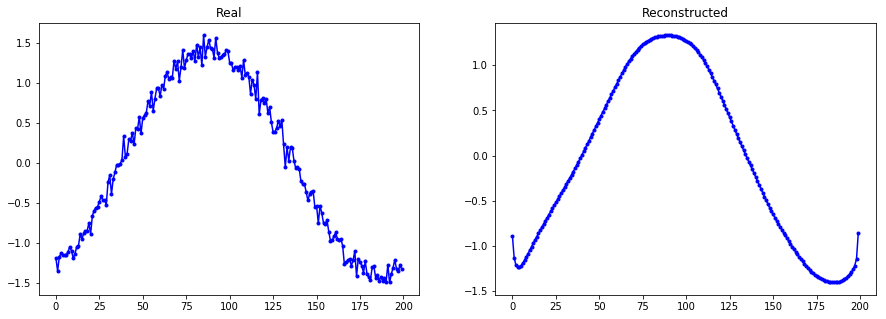

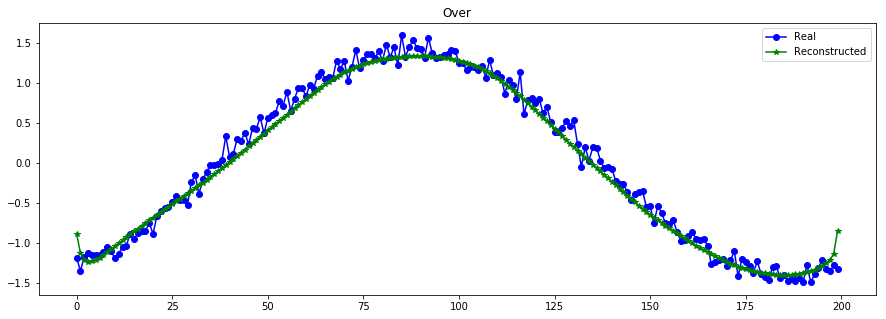

----------------------------------------------------------------


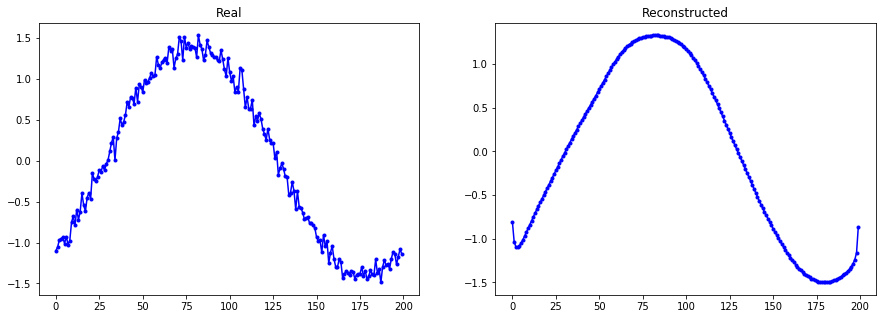

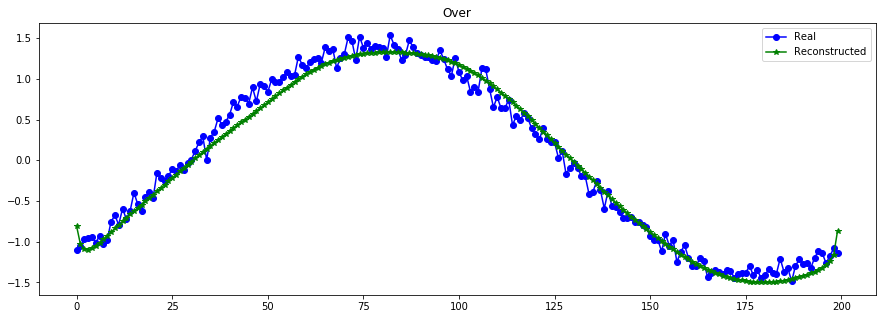

----------------------------------------------------------------


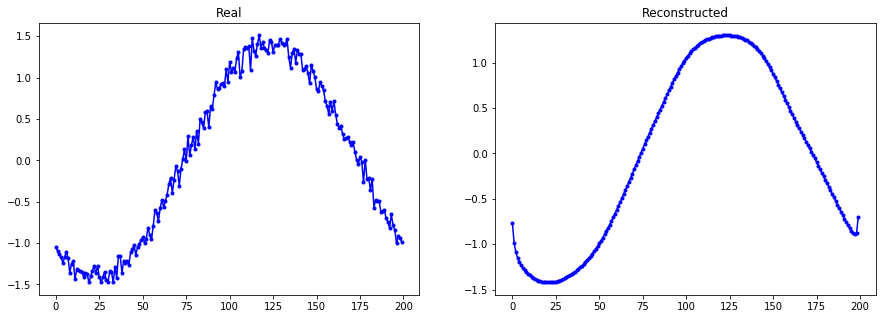

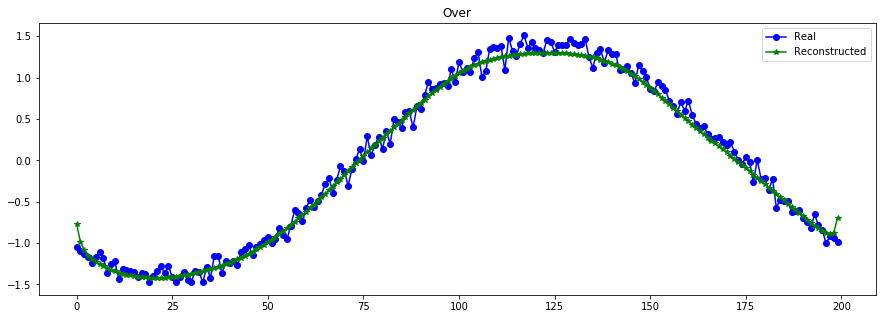

----------------------------------------------------------------


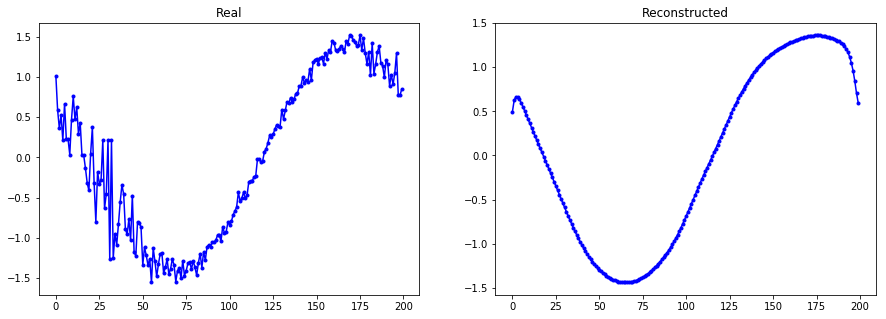

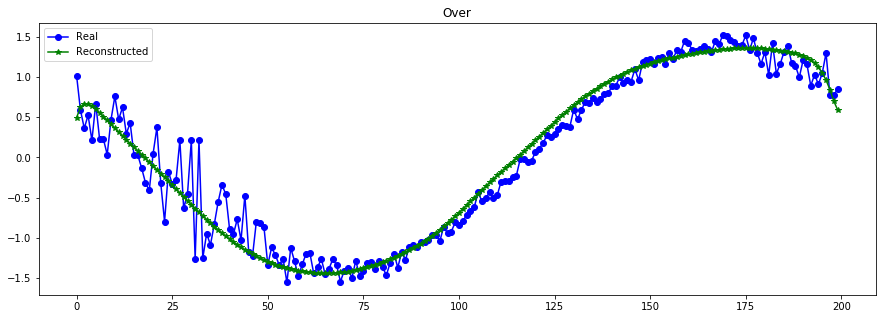

----------------------------------------------------------------


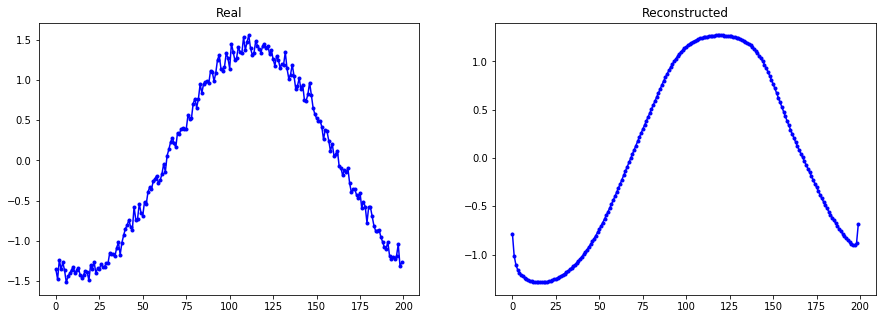

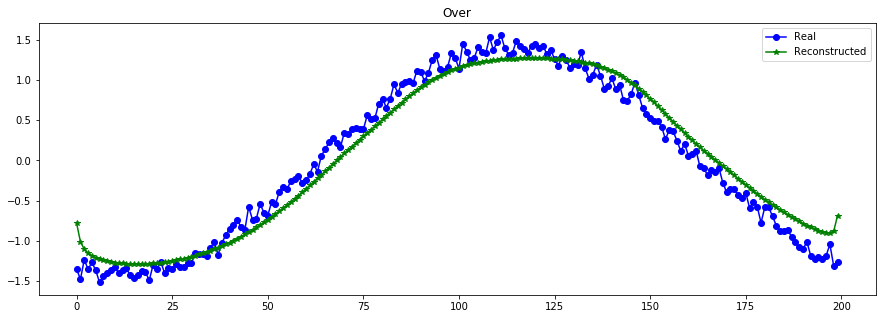

----------------------------------------------------------------


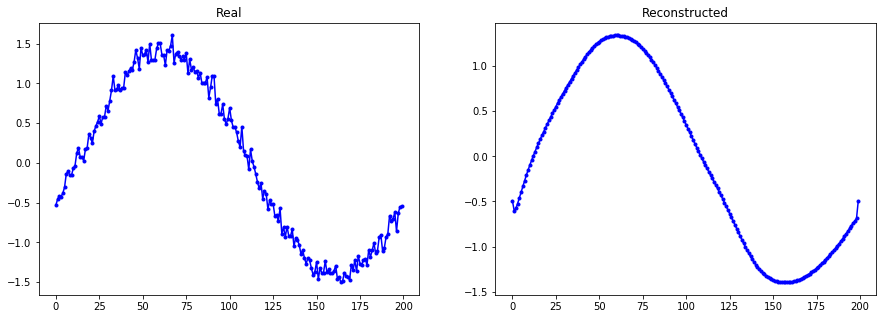

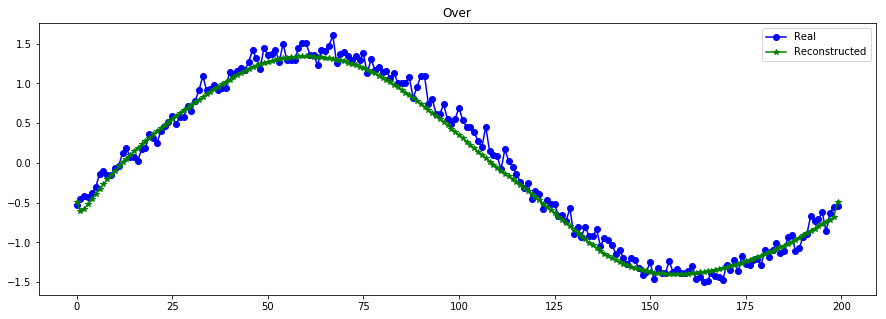

----------------------------------------------------------------


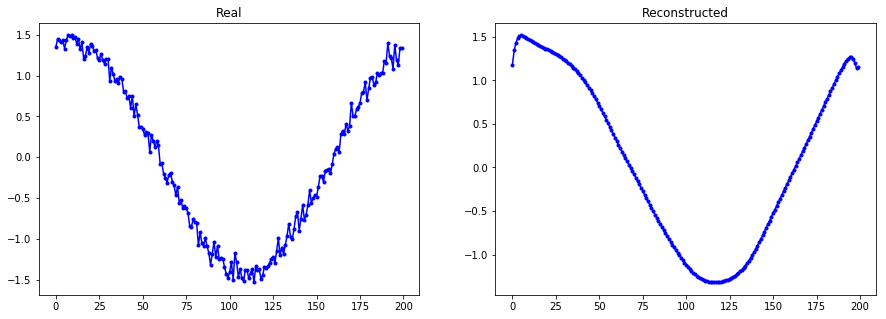

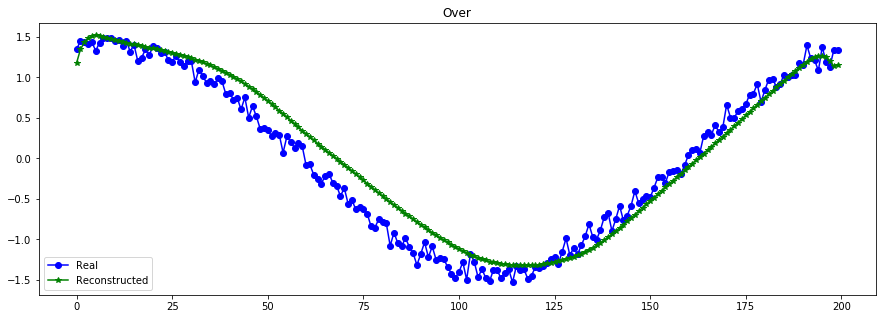

----------------------------------------------------------------


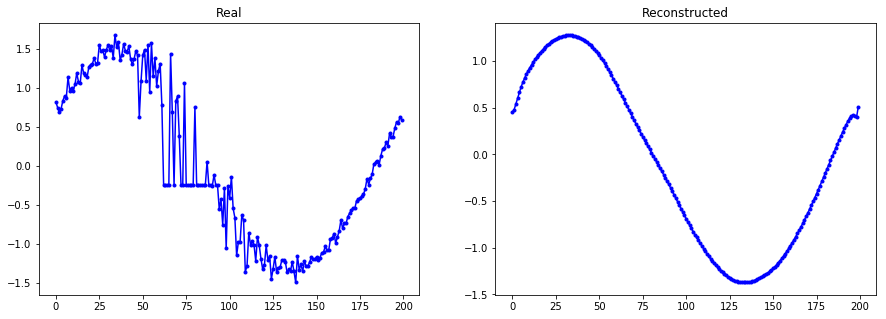

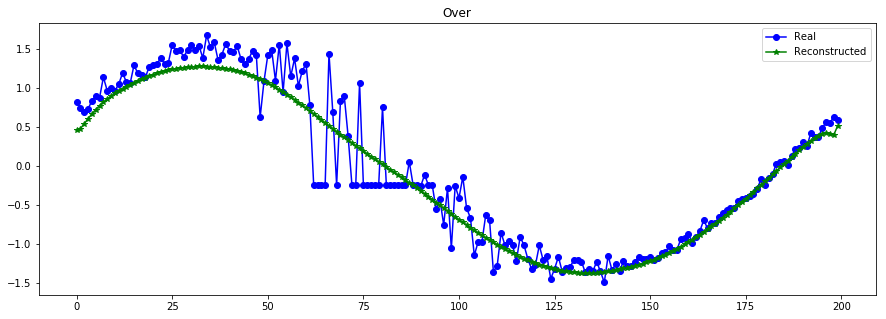

----------------------------------------------------------------


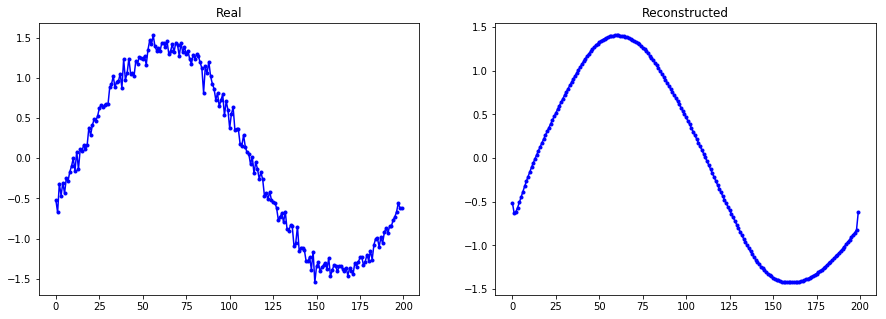

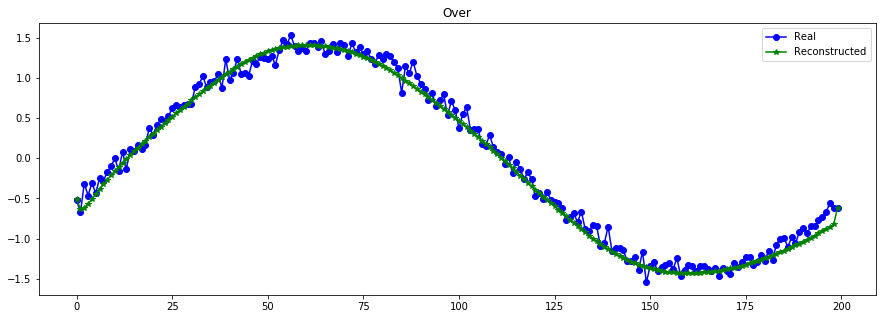

----------------------------------------------------------------


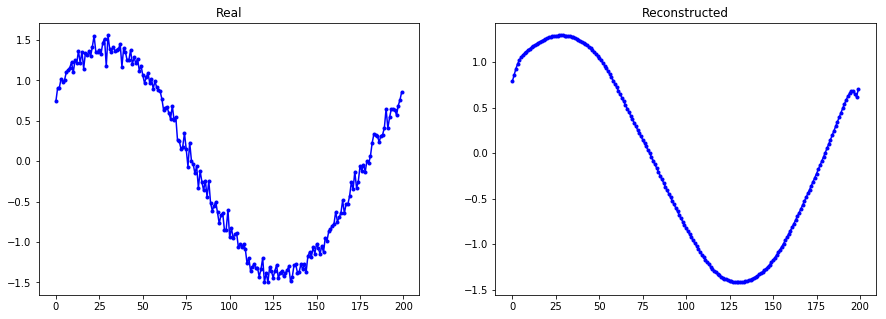

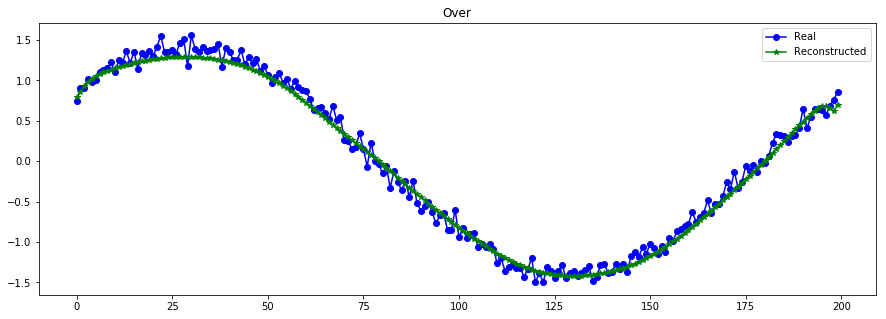

----------------------------------------------------------------


In [312]:
X_train_hat = vae.predict(X_train, batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [287]:
D = 32 #data to plot...

In [288]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(CuDNNGRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(CuDNNGRU(64, return_sequences=False))(f1) #bidirectional

#f1 = Dense(D, activation='relu')(f1)

z_mean = Dense(latent_dim, activation='linear')(f1)
z_log_var = Dense(latent_dim, activation='linear')(f1) # so std = 0.5*z_log_var

encoder = Model([x_t, x_lc], z_mean, name="encoder")

z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

#decode = Dense(D, activation='relu')(decoder_input)

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(CuDNNGRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_loss,  metrics = [KL_loss, MSE_loss])

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 16)           104736      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       106497      T_inp[0][0]                      
          

In [289]:
batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=10, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

Train on 3457 samples, validate on 1543 samples
Epoch 1/10
3457/3457 [==============================] - 30s 9ms/step - loss: 200.8143 - KL_loss: 1.1188 - MSE_loss: 0.9985 - val_loss: 208.2843 - val_KL_loss: 4.9462 - val_MSE_loss: 1.0167
Epoch 2/10
3457/3457 [==============================] - 9s 3ms/step - loss: 172.0922 - KL_loss: 6.1310 - MSE_loss: 0.8298 - val_loss: 146.3020 - val_KL_loss: 8.8659 - val_MSE_loss: 0.6872
Epoch 3/10
3457/3457 [==============================] - 9s 3ms/step - loss: 107.7481 - KL_loss: 11.6417 - MSE_loss: 0.4805 - val_loss: 163.0812 - val_KL_loss: 14.3390 - val_MSE_loss: 0.7437
Epoch 4/10
3457/3457 [==============================] - 9s 3ms/step - loss: 69.6022 - KL_loss: 12.8274 - MSE_loss: 0.2839 - val_loss: 76.0912 - val_KL_loss: 14.5668 - val_MSE_loss: 0.3076
Epoch 5/10
3457/3457 [==============================] - 9s 3ms/step - loss: 51.4205 - KL_loss: 16.1249 - MSE_loss: 0.1765 - val_loss: 53.3322 - val_KL_loss: 18.6693 - val_MSE_loss: 0.1733
Epoch 6/1

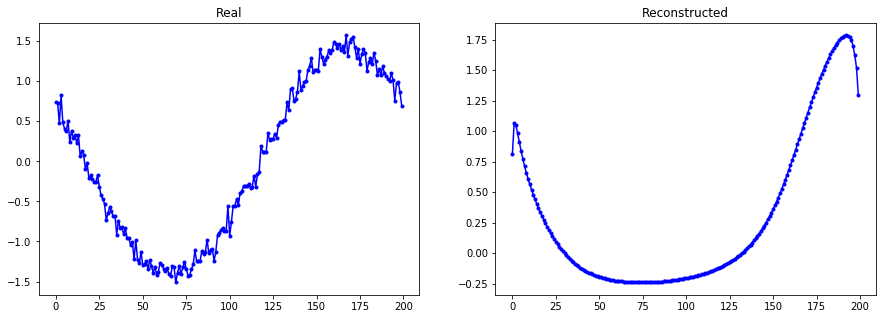

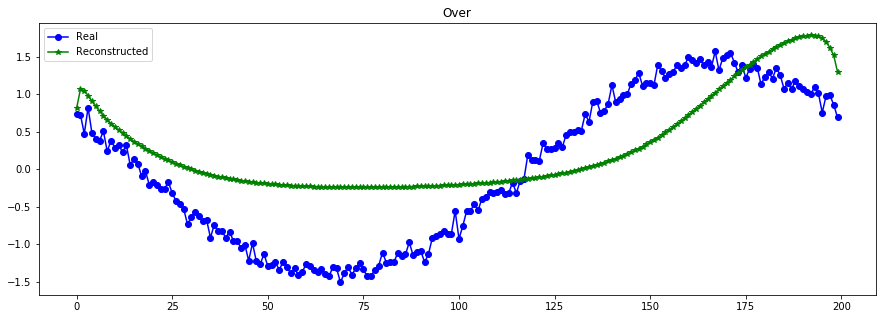

----------------------------------------------------------------


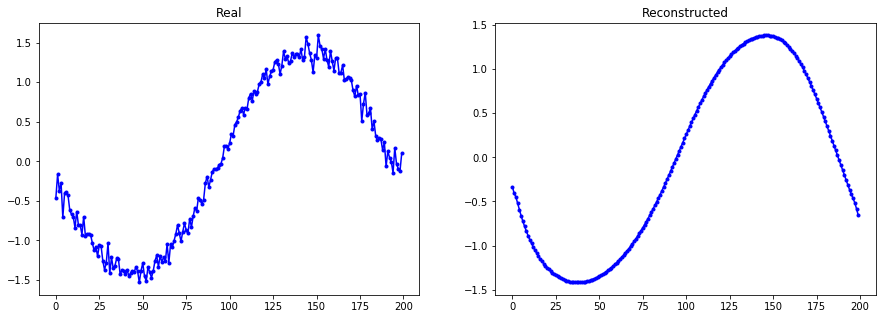

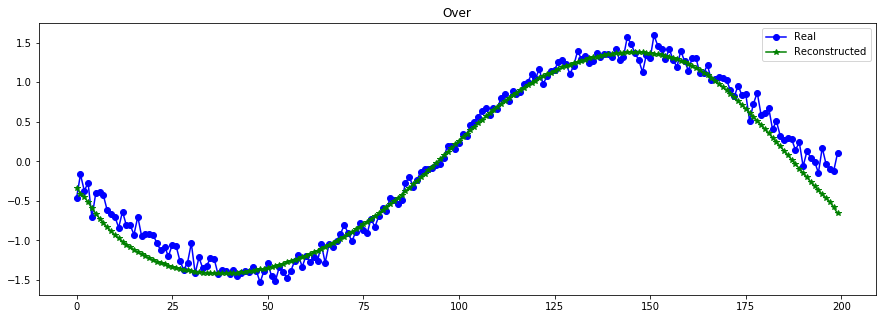

----------------------------------------------------------------


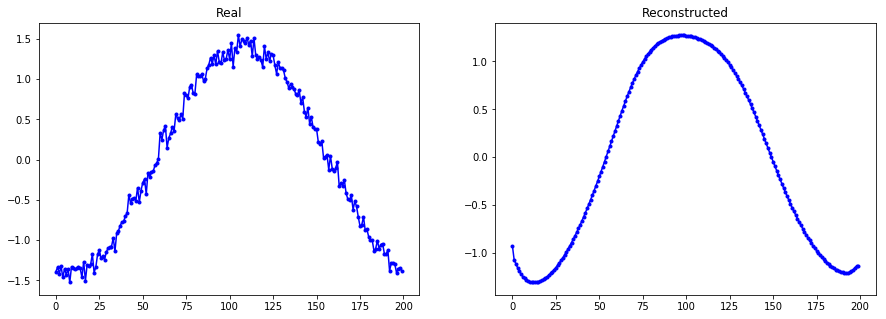

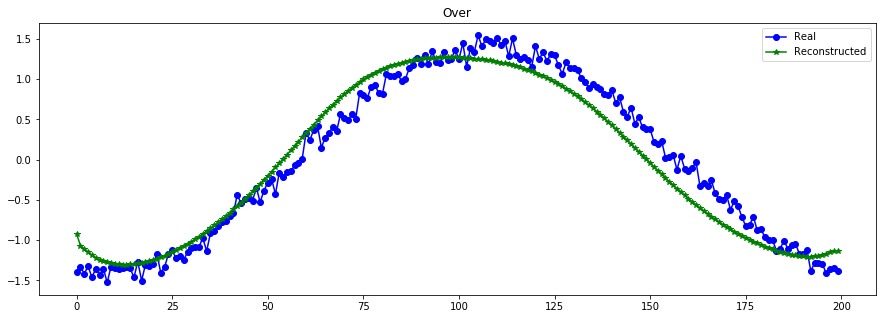

----------------------------------------------------------------


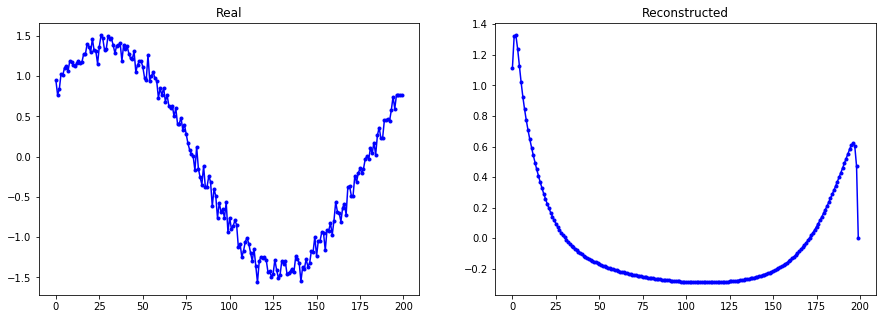

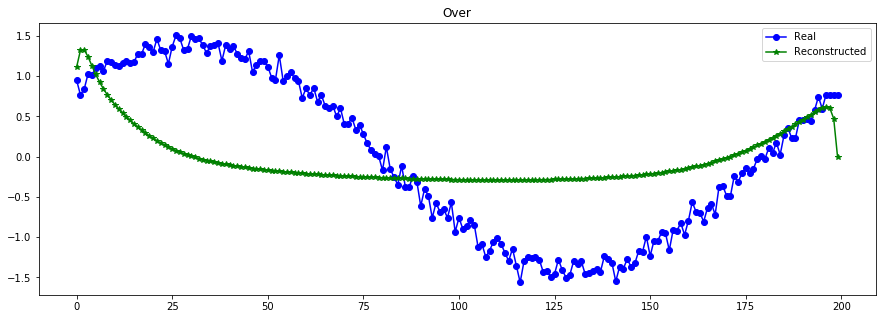

----------------------------------------------------------------


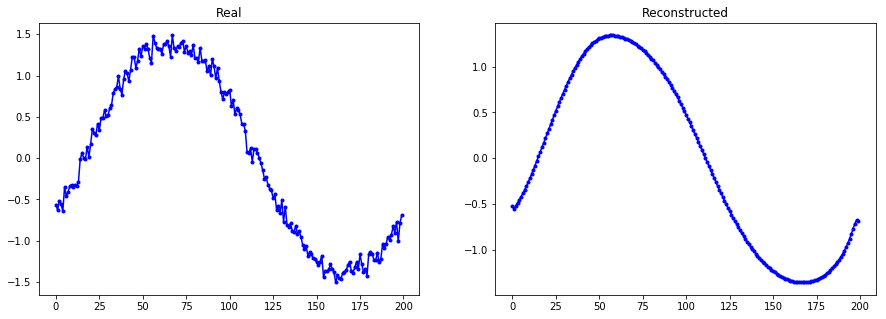

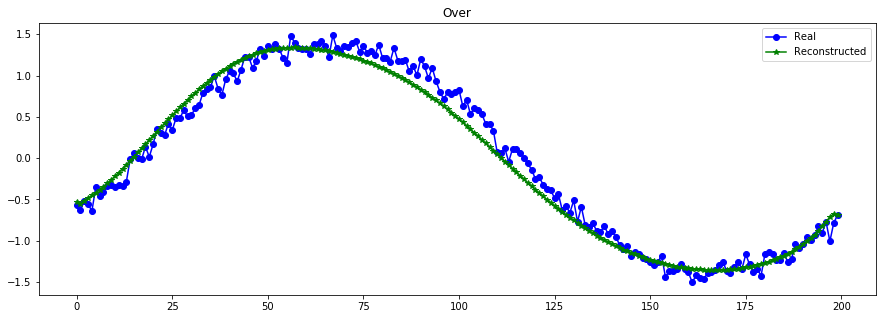

----------------------------------------------------------------


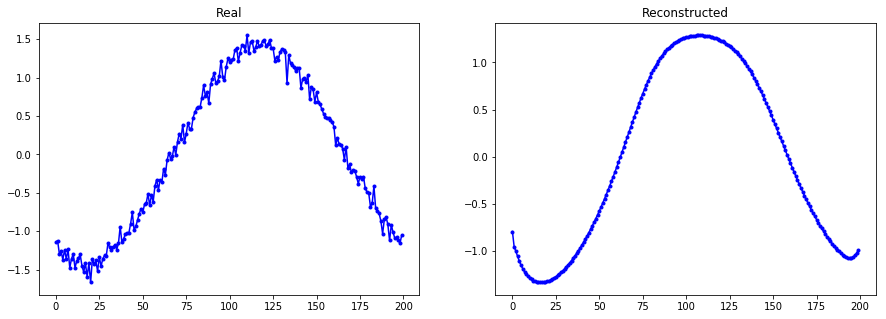

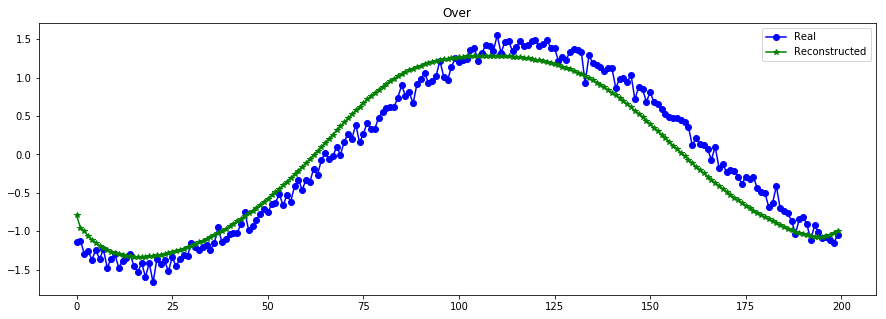

----------------------------------------------------------------


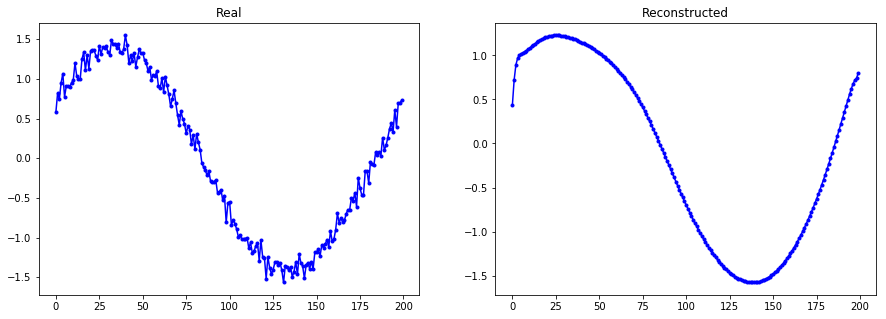

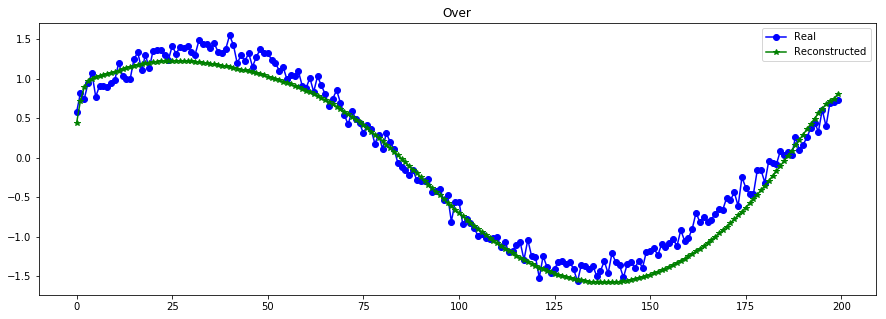

----------------------------------------------------------------


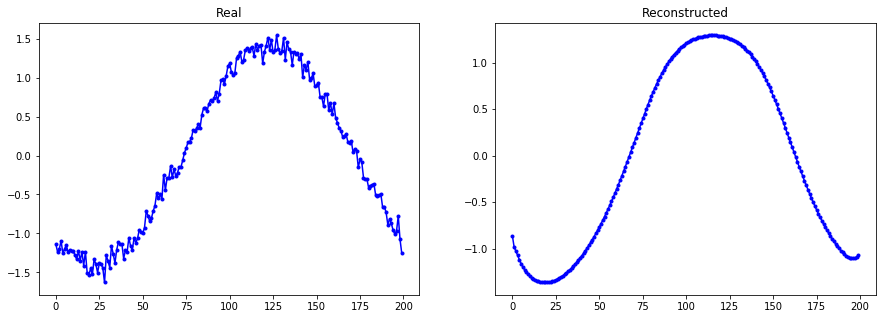

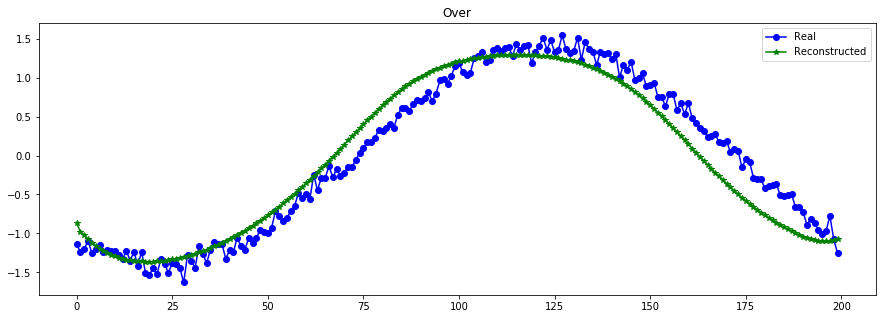

----------------------------------------------------------------


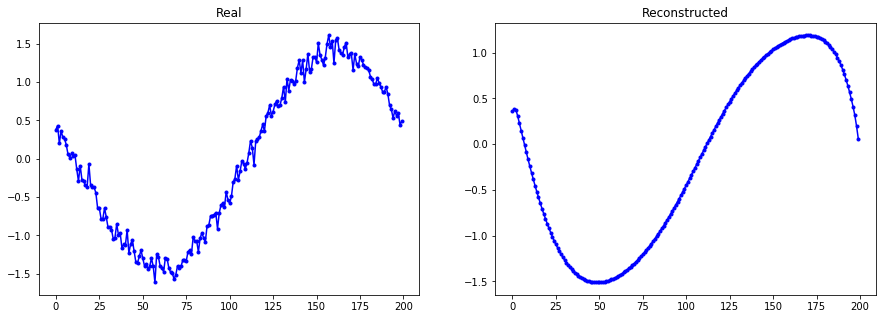

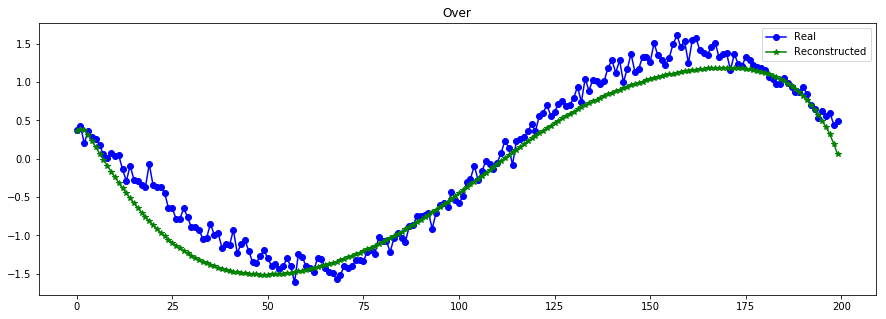

----------------------------------------------------------------


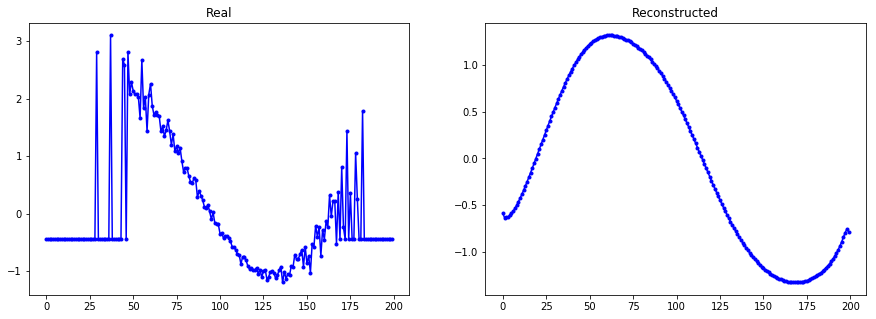

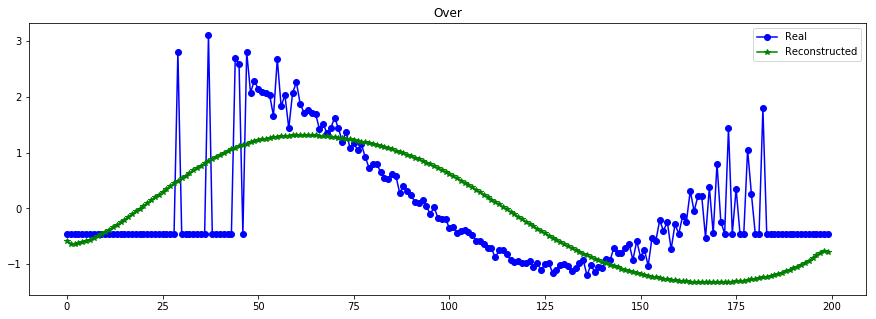

----------------------------------------------------------------


In [290]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [257]:
encoder_all = Model([x_t, x_lc], [z_mean, z_log_var], name="encoder")
z_aux, z_var_aux = encoder_all.predict([X_train_t,X_train])

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


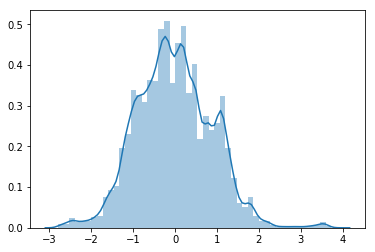

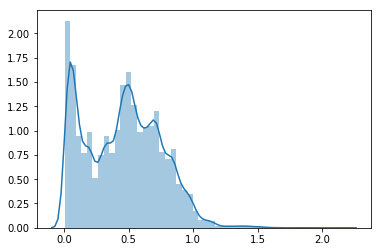

In [258]:
##### kl normal y sse
sns.distplot(z_aux.flatten())
plt.show()

sns.distplot(np.exp(z_var_aux.flatten()))
plt.show()

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


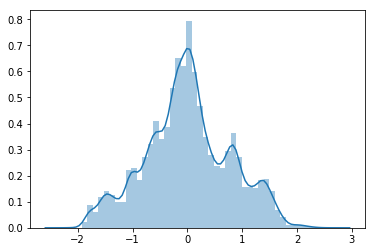

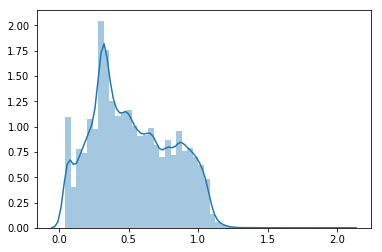

In [155]:
##### kl peso bajo
sns.distplot(z_aux.flatten())
plt.show()

sns.distplot(np.exp(z_var_aux.flatten()))
plt.show()

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


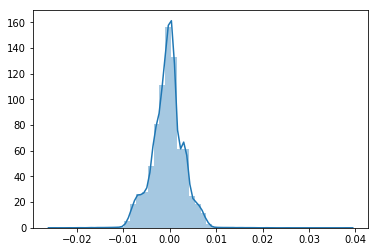

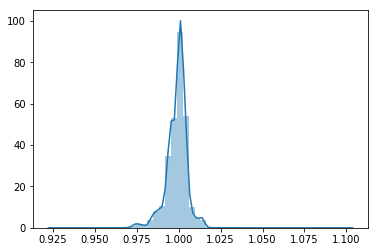

In [134]:
##### full kl (mal reconstruccion)

sns.distplot(z_aux.flatten())
plt.show()

sns.distplot(np.exp(z_var_aux.flatten()))
plt.show()

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


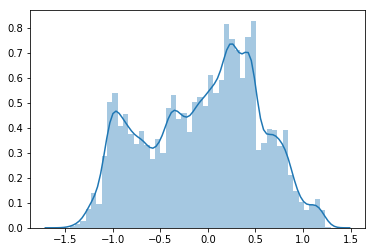

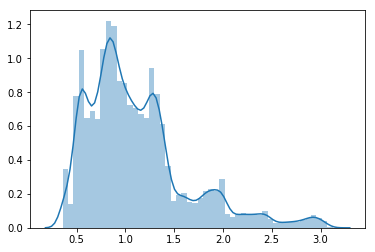

In [118]:
#sin kl
ns.distplot(z_aux.flatten())
plt.show()

sns.distplot(np.exp(z_var_aux.flatten()))
plt.show()

### generate..

In [210]:
def generate_VAE(z_sampleds, t_s):
    N = z_sampleds.shape[0]
    t_inp = np.concatenate([[0], np.diff(t_s)]) #differences
    t_inp = np.tile(t_inp, (N,1))[:,:,None] 
    return generator.predict([t_inp, z_sampleds])

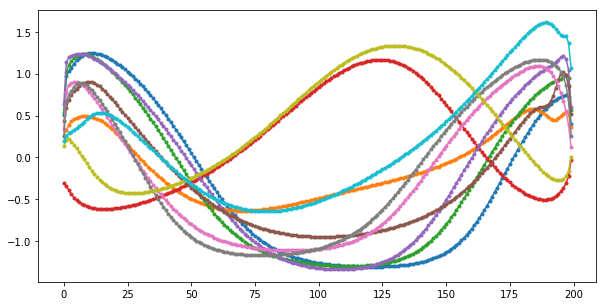

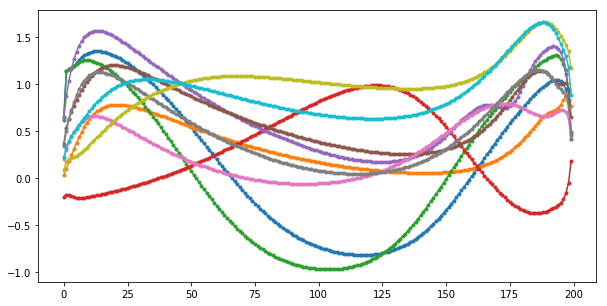

In [211]:
## generate random
n = 10

z_sampleds = np.random.normal(0, 1, size=(n,latent_dim))

t_s = np.linspace(0, 1, 200)

x_decoded = generate_VAE(z_sampleds, t_s)
plt.figure(figsize=(10,5))
for i in range(n):
    
    plt.plot(x_decoded[i,:,0], '.-')
plt.show()


t_s = np.linspace(0, 1000, 200)

x_decoded = generate_VAE(z_sampleds, t_s)
plt.figure(figsize=(10,5))
for i in range(n):
    
    plt.plot(x_decoded[i,:,0], '.-')
plt.show()

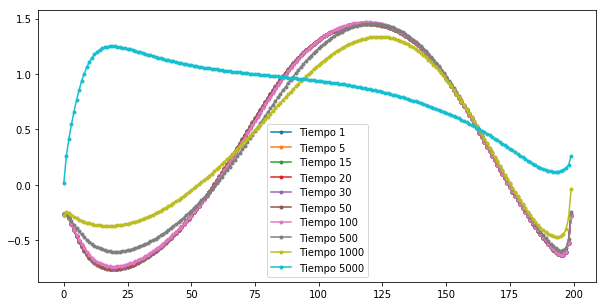

In [215]:
## generate random
n = 10

z_sampleds = np.random.normal(0, 1, size=(1,latent_dim))

times = [1,5,15,20,30,50,100,500,1000,5000]

plt.figure(figsize=(10,5))
for i in range(n):
    t_s = np.linspace(0, times[i], 200)

    x_decoded = generate_VAE(z_sampleds, t_s)

    plt.plot(x_decoded[0,:,0], '.-', label='Tiempo '+str(times[i]))
plt.legend()
plt.show()


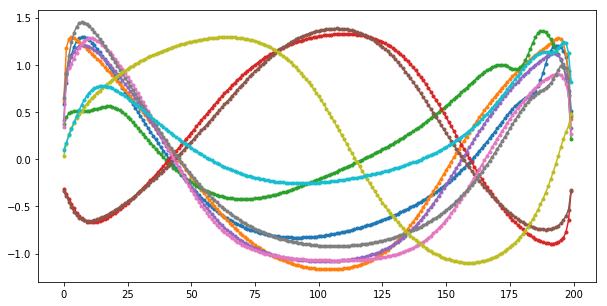

In [172]:
## generate random
n = 10

z_sampleds = np.random.normal(0, 1, size=(n,latent_dim))

t_s = np.linspace(0, 10, 200)


t_inp = np.concatenate([[0], np.diff(t_s)]) #differences
t_inp = np.tile(t_inp, (n,1))[:,:,None] 

x_decoded = generator.predict([t_inp, z_sampleds])

plt.figure(figsize=(10,5))
for i in range(n):
    
    plt.plot(x_decoded[i,:,0], '.-')
plt.show()

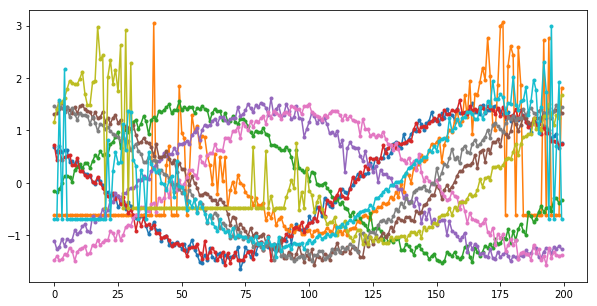

In [168]:
plt.figure(figsize=(10,5))
for i in range(n):
    
    plt.plot(X_train[i,:,0], '.-')
plt.show()